<a href="https://colab.research.google.com/github/Zobaid/Youtube_Subtitle_Extraction_and_NLP/blob/master/Youtube_subtitle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install --upgrade google-api-python-client

In [ ]:
pip install --upgrade google-auth-oauthlib google-auth-httplib2


In [9]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
%cd "./gdrive/My Drive/Colab Notebooks/Youtube_Scrapper/"
!ls -l

[Errno 2] No such file or directory: './gdrive/My Drive/Colab Notebooks/Youtube_Scrapper/'
/content/gdrive/My Drive/Colab Notebooks/Youtube_Scrapper
total 110
drwx------ 2 root root  4096 Jul 19 12:33 assets
-rw------- 1 root root   416 Jul 19 11:53 client_secret_185548826901-2f7em2ubgdu8pgsbvo7k763e82okg2tq.apps.googleusercontent.com.json
-rw------- 1 root root  7120 Jul 17 14:23 extract_video_info.ipynb
-rw------- 1 root root 65440 Jul 19 13:05 nlp_utils.py
-rw------- 1 root root  2336 Jul 17 11:52 srapwithvs4.py
-rw------- 1 root root 32431 Jul 19 13:02 Youtube_subtitle.ipynb


In [11]:
import pandas as pd
import os
import google.oauth2.credentials
import google_auth_oauthlib.flow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow
CLIENT_SECRETS_FILE = "client_secret_185548826901-2f7em2ubgdu8pgsbvo7k763e82okg2tq.apps.googleusercontent.com.json"
SCOPES = ['https://www.googleapis.com/auth/youtube.force-ssl']
API_SERVICE_NAME = 'youtube'
API_VERSION = 'v3'
def get_authenticated_service():
    flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
    credentials = flow.run_console()
    return build(API_SERVICE_NAME, API_VERSION, credentials = credentials)
# Remove keyword arguments that are not set
def remove_empty_kwargs(**kwargs):
    good_kwargs = {}
    if kwargs is not None:
        for key, value in kwargs.items():
            if value:
                good_kwargs[key] = value
    return good_kwargs

In [12]:
client = get_authenticated_service()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=185548826901-2f7em2ubgdu8pgsbvo7k763e82okg2tq.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=siKCN6NkeJgpYey4vgHtIEIBzHSPEx&prompt=consent&access_type=offline
Enter the authorization code: 4/2AHsqmFE7VEOvYO4z2twlBG3q_FMtWEw10PNF50H9QjkcxQgHPybTrQ


In [13]:
def youtube_keyword(client, **kwargs):    
    kwargs = remove_empty_kwargs(**kwargs)
    response = client.search().list(
        **kwargs
        ).execute()    
    return response

In [18]:
def youtube_search (criteria,max_res):   
    #create lists and empty dataframe
    titles = []
    videoIds = []
    channelIds = []
    resp_df = pd.DataFrame()
    
    while len(titles) < max_res:
        token = None
        response = youtube_keyword(client,
                        part='id,snippet',
                        maxResults=50,
                        q=criteria,
                        videoCaption='closedCaption',
                        type='video', 
                        videoDuration='medium',
                        pageToken=token) 
                                         
        for item in response['items']:        
            titles.append(item['snippet']['title'])
            channelIds.append(item['snippet']['channelTitle'])
            videoIds.append(item['id']['videoId'])
        
        token = response['nextPageToken']
        
    resp_df['title'] = titles
    resp_df['channelId'] = channelIds
    resp_df['videoId'] = videoIds
    resp_df['subject'] = criteria
    
    return resp_df

In [27]:
Addidas_ultraboost_Videos = youtube_search('[Addidas+ultraboost]',50)
Addidas_ultraboost_Videos.shape
#output: (1000,4)
Addidas_ultraboost_Videos.head()

title  ...               subject
0  The Rise and Fall of Adidas Boost: What Happened?  ...  [Addidas+ultraboost]
1               What&#39;s inside Adidas Boost Ball?  ...  [Addidas+ultraboost]
2  Nike Epic React vs Adidas Ultra Boost - The Tr...  ...  [Addidas+ultraboost]
3  Adidas UltraBoost 20 (ISS) | Unboxing &amp; On...  ...  [Addidas+ultraboost]
4  ADIDAS ULTRABOOST SUMMER.RDY - UNBOXING - TEST...  ...  [Addidas+ultraboost]

[5 rows x 4 columns]

In [31]:
!pip install youtube-dl

     |████████████████████████████████| 1.8MB 2.8MB/s 


In [35]:
def get_all_ccs(videos):
    base_url = 'https://www.youtube.com/watch?v='
    lang="en"
    for i in videos:
        url = base_url + i
        cmd = ["youtube-dl","--skip-download","--write-sub",
               "--sub-lang",lang,url]
        os.system(" ".join(cmd))

In [36]:
get_all_ccs(Addidas_ultraboost_Videos.videoId)

In [37]:
filenames_vtt = [os.fsdecode(file) for file in os.listdir(os.getcwd()) if os.fsdecode(file).endswith(".vtt")]
#Check file names
filenames_vtt[:2]

['The Rise and Fall of Adidas Boost - What Happened-pH2_IcMSol0.en.vtt',
 "What's inside Adidas Boost Ball-QYgs5YBWr14.en.vtt"]

In [39]:
!pip install webvtt-py

In [40]:
import webvtt
def convert_vtt(filenames):    
    #create an assets folder if one does not yet exist
    if os.path.isdir('{}/assets'.format(os.getcwd())) == False:
        os.makedirs('assets')
    #extract the text and times from the vtt file
    for file in filenames:
        captions = webvtt.read(file)
        text_time = pd.DataFrame()
        text_time['text'] = [caption.text for caption in captions]
        text_time['start'] = [caption.start for caption in captions]
        text_time['stop'] = [caption.end for caption in captions]
        text_time.to_csv('assets/{}.csv'.format(file[:-4]),index=False) #-4 to remove '.vtt'
        #remove files from local drive
        os.remove(file)

In [41]:
convert_vtt(filenames_vtt)

In [42]:
csv_files = [os.fsdecode(file) for file in os.listdir(os.getcwd()+'/assets') if os.fsdecode(file).endswith('.csv')]
#take a look at a file name
csv_files[0]

'The Rise and Fall of Adidas Boost - What Happened-pH2_IcMSol0.en.csv'

In [43]:
path = 'assets/'
for filename in csv_files:
    os.rename(os.path.join(path, filename), os.path.join(path, filename.replace(' ', '')))
#to verify the results
clean_csv = [os.fsdecode(file) for file in os.listdir(os.getcwd()+'/assets')]
clean_csv[0]

'TheRiseandFallofAdidasBoost-WhatHappened-pH2_IcMSol0.en.csv'

In [45]:
#extract the text and videoid
vidText = []
csv_vidid = []

for file in clean_csv:
   df = pd.read_csv(path+file)
   text = " ".join(df.text)
   vidText.append(text)
   csv_vidid.append(file[-18:-7])

In [46]:
Addidas_vid = pd.DataFrame()
Addidas_vid['vid_title'] = clean_csv
Addidas_vid['vid_text'] = vidText
Addidas_vid['vid_id'] = csv_vidid

In [51]:
Addidas_vid.head(1)

vid_title  ...       vid_id
0  TheRiseandFallofAdidasBoost-WhatHappened-pH2_I...  ...  pH2_IcMSol0

[1 rows x 3 columns]

In [52]:
Addidas_ultraboost_Videos.head(1)

title  ...               subject
0  The Rise and Fall of Adidas Boost: What Happened?  ...  [Addidas+ultraboost]

[1 rows x 4 columns]

In [56]:
base_df = Addidas_vid.set_index('vid_id').join(Addidas_ultraboost_Videos.set_index('videoId')).reset_index()
#base_df = base_df.drop_duplicates(subset=['index'])
base_df.head()

vid_id  ...               subject
0  pH2_IcMSol0  ...  [Addidas+ultraboost]
1  QYgs5YBWr14  ...  [Addidas+ultraboost]
2  fVtO4RWRAiw  ...  [Addidas+ultraboost]
3  aNBP-KQKB2o  ...  [Addidas+ultraboost]
4  ZOrufstBacY  ...  [Addidas+ultraboost]

[5 rows x 6 columns]

In [60]:
base_df.vid_text[1] [:500]

"- A sharp knife. A rubber Boost ball. - Oh my goodness. (upbeat music) - Look at all this Adidas\nBoost, all over our floor, all over this table right here, this is all Adidas Boost, and\nLincoln is messing with it. - It's so awesome. - We got this crate, directly from Adidas, and it's a collaboration that they did with the ISS National Labs,\nwhich is the space-station. We just did a twitter live stream, where we unboxed this,\nand took apart the shoes that were in it. Check this out, this is a cra"

In [77]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 19 21:05:10 2020

@author: Ultimate-SK
"""


## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for analysis
import re
import langdetect 
import nltk
import wordcloud

## for sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

## for ner
import spacy
import collections

## for machine learning
from sklearn import preprocessing, model_selection, feature_extraction, feature_selection, metrics, manifold, naive_bayes, pipeline, decomposition

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for explainer
from lime import lime_text
import shap

## for W2V
import gensim
import gensim.downloader as gensim_api

## for bert
import transformers



###############################################################################
#                  TEXT ANALYSIS                                              #
###############################################################################
'''
Plot univariate and bivariate distributions.
'''
def utils_plot_distributions(dtf, x, top=None, y=None, bins=None, figsize=(10,5)):
    ## univariate
    if y is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(x, fontsize=15)
        if top is None:
            dtf[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
        else:   
            dtf[x].reset_index().groupby(x).count().sort_values(by="index").tail(top).plot(kind="barh", legend=False, ax=ax).grid(axis='x')
        ax.set(ylabel=None)

    ## bivariate
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
        fig.suptitle(x, fontsize=15)
        for i in dtf[y].unique():
            sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, bins=bins, hist_kws={"alpha":0.8}, axlabel="", ax=ax[0])
            sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, kde_kws={"shade":True}, axlabel="", ax=ax[1])
        ax[0].set(title="histogram")
        ax[0].grid(True)
        ax[0].legend(dtf[y].unique())
        ax[1].set(title="density")
        ax[1].grid(True)
    plt.show()



'''
Detect language of text.
'''
def add_detect_lang(dtf, column):
    dtf['lang'] = dtf[column].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
    return dtf



'''
Compute different text length metrics.
:parameter
    :param dtf: dataframe - dtf with a text column
    :param column: string - name of column containing text
:return
    dtf: input dataframe with 2 new columns
'''
def add_text_length(dtf, column):
    dtf['word_count'] = dtf[column].apply(lambda x: len(str(x).split(" ")))
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(str(x).split(".")))
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['word_count','char_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf



'''
Computes the sentiment using Textblob or Vader.
:parameter
    :param dtf: dataframe - dtf with a text column
    :param column: string - name of column containing text
    :param algo: string - "textblob" or "vader"
    :param sentiment_range: tuple - if not (-1,1) score is rescaled with sklearn
:return
    dtf: input dataframe with new sentiment column
'''
def add_sentiment(dtf, column, algo="vader", sentiment_range=(-1,1)):
    ## calculate sentiment
    if algo == "vader":
        vader = SentimentIntensityAnalyzer()
        dtf["sentiment"] = dtf[column].apply(lambda x: vader.polarity_scores(x)["compound"])
    elif algo == "textblob":
        dtf["sentiment"] = dtf[column].apply(lambda x: TextBlob(x).sentiment.polarity)
    ## rescaled
    if sentiment_range != (-1,1):
        dtf["sentiment"] = preprocessing.MinMaxScaler(feature_range=sentiment_range).fit_transform(dtf[["sentiment"]])
    print(dtf[['sentiment']].describe().T)
    return dtf



'''
Creates a list of stopwords.
:parameter
    :param lst_langs: list - ["english", "italian"]
    :param lst_add_words: list - list of new stopwords to add
    :param lst_keep_words: list - list words to keep (exclude from stopwords)
:return
    stop_words: list of stop words
'''      
def create_stopwords(lst_langs=["english"], lst_add_words=[], lst_keep_words=[]):
    lst_stopwords = set()
    for lang in lst_langs:
        lst_stopwords = lst_stopwords.union( set(nltk.corpus.stopwords.words(lang)) )
    lst_stopwords = lst_stopwords.union(lst_add_words)
    lst_stopwords = list(set(lst_stopwords) - set(lst_keep_words))
    return sorted(list(set(lst_stopwords)))



'''
Preprocess a string.
:parameter
    :param txt: string - name of column containing text
    :param lst_regex: list - list of regex to remove
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(txt, lst_regex=None, lst_stopwords=None, flg_stemm=False, flg_lemm=True):
    ## regex (in case, before processing)
    if lst_regex is not None: 
        for regex in lst_regex:
            txt = re.sub(regex, '', txt)
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    txt = re.sub(r'[^\w\s]', '', str(txt).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## remove leftover Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
            
    ## back to string from list
    txt = " ".join(lst_txt)
    return txt



'''
Adds a column of preprocessed text.
:parameter
    :param dtf: dataframe - dtf with a text column
    :param column: string - name of column containing text
:return
    dtf: input dataframe with two new columns
'''
def add_preprocessed_text(dtf, column, lst_regex=None, lst_stopwords=None, flg_stemm=False, flg_lemm=True, remove_na=True):
    ## apply preprocess
    dtf = dtf[ pd.notnull(dtf[column]) ]
    dtf[column+"_clean"] = dtf[column].apply(lambda x: utils_preprocess_text(x, lst_regex, lst_stopwords, flg_stemm, flg_lemm))
    
    ## residuals
    dtf["check"] = dtf[column+"_clean"].apply(lambda x: len(x))
    if dtf["check"].min() == 0:
        print("--- found NAs ---")
        print(dtf[[column,column+"_clean"]][dtf["check"]==0].head())
        if remove_na is True:
            dtf = dtf[dtf["check"]>0] 
            
    return dtf.drop("check", axis=1)



'''
Compute n-grams frequency.
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq



'''
Plots a wordcloud from a list of Docs or from a dictionary
:parameter
    :param corpus: list - dtf["text"]
'''
def plot_wordcloud(corpus, max_words=150, max_font_size=35, figsize=(10,10)):
    wc = wordcloud.WordCloud(background_color='black', max_words=max_words, max_font_size=max_font_size)
    wc = wc.generate(str(corpus)) #if type(corpus) is not dict else wc.generate_from_frequencies(corpus)     
    fig = plt.figure(num=1, figsize=figsize)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show()



'''
Adds a column with word frequency.
:parameter
    :param dtf: dataframe - dtf with a text column
    :param column: string - name of column containing text
    :param lst_words: list - ["donald trump", "china", ...]
    :param freq: str - "count" or "tfidf"
:return
    dtf: input dataframe with new columns
'''
def add_word_freq(dtf, column, lst_words, freq="count"):
    ## query
    print("found records:")
    print([word+": "+str(len(dtf[dtf[column].str.contains(word)])) for word in lst_words])
    
    ## vectorizer
    lst_grams = [len(word.split(" ")) for word in lst_words]
    if freq == "tfidf":
        vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=lst_words, ngram_range=(min(lst_grams),max(lst_grams)))
    else:
        vectorizer = feature_extraction.text.CountVectorizer(vocabulary=lst_words, ngram_range=(min(lst_grams),max(lst_grams)))
    dtf_X = pd.DataFrame(vectorizer.fit_transform(dtf[column]).todense(), columns=lst_words)
    
    ## join
    for word in lst_words:
        dtf[word] = dtf_X[word]
    return dtf


        
###############################################################################
#                            NER                                              #
###############################################################################
'''
Display the spacy NER model.
:parameter
    :param txt: string - text input for the model.
    :param model: string - "en_core_web_lg", "en_core_web_sm", "xx_ent_wiki_sm"
    :param lst_tag_filter: list or None - example ["ORG", "GPE", "LOC"], None for all tags
    :param title: str or None
'''
def ner_displacy(txt, ner=None, lst_tag_filter=None, title=None, serve=False):
    ner = spacy.load("en_core_web_lg") if ner is None else ner
    doc = ner(txt)
    doc.user_data["title"] = title
    if serve == True:
        spacy.displacy.serve(doc, style="ent", options={"ents":lst_tag_filter})
    else:
        spacy.displacy.render(doc, style="ent", options={"ents":lst_tag_filter})



'''
Find entities in text, replace strings with tags and extract tags:
    Donald Trump --> Donald_Trump
    [Donald Trump, PERSON]
'''
def utils_ner_text(txt, ner=None, lst_tag_filter=None, grams_join="_"):
    ## apply model
    ner = spacy.load("en_core_web_lg") if ner is None else ner
    entities = ner(txt).ents

    ## tag text
    tagged_txt = txt
    for tag in entities:
        if (lst_tag_filter is None) or (tag.label_ in lst_tag_filter):
            try:
                tagged_txt = re.sub(tag.text, grams_join.join(tag.text.split()), tagged_txt) #it breaks with wild characters like *+
            except Exception as e:
                next

    ## extract tags list
    if lst_tag_filter is None:
        lst_tags = [(tag.text, tag.label_) for tag in entities]  #list(set([(word.text, word.label_) for word in ner(x).ents]))
    else: 
        lst_tags = [(word.text, word.label_) for word in entities if word.label_ in lst_tag_filter]

    return tagged_txt, lst_tags
        
        

'''
Counts the elements in a list.
:parameter
    :param lst: list
    :param top: num - number of top elements to return
:return
    lst_top - list with top elements
'''
def utils_lst_count(lst, top=None):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict(sorted(dic_counter.items(), key=lambda x: x[1], reverse=True))
    lst_top = [ {key:value} for key,value in dic_counter.items() ]
    if top is not None:
        lst_top = lst_top[:top]
    return lst_top



'''
Creates columns
    :param lst_dics_tuples: [{('Texas','GPE'):1}, {('Trump','PERSON'):3}]
    :param tag: string - 'PERSON'
:return
    int
'''
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]   #pd.DataFrame([dic_counter])
    else:
        return 0



'''
Apply spacy NER model and add tag features.
:parameter
    :param dtf: dataframe - dtf with a text column
    :param column: string - name of column containing text
    :param ner: spacy object - "en_core_web_lg", "en_core_web_sm", "xx_ent_wiki_sm"
    :param lst_tag_filter: list - ["ORG","PERSON","NORP","GPE","EVENT", ...]. If None takes all
    :param grams_join: string - "_", " ", or more (ex. "new york" --> "new_york")
    :param create_features: bool - create columns with category features
:return
    dtf
'''
def add_ner_spacy(dtf, column, ner=None, lst_tag_filter=None, grams_join="_", create_features=True):
    ner = spacy.load("en_core_web_lg") if ner is None else ner

    ## tag text and exctract tags
    print("--- tagging ---")
    dtf[[column+"_tagged", "tags"]] = dtf[[column]].apply(lambda x: utils_ner_text(x[0], ner, lst_tag_filter, grams_join), 
                                                          axis=1, result_type='expand')

    ## put all tags in a column
    print("--- counting tags ---")
    dtf["tags"] = dtf["tags"].apply(lambda x: utils_lst_count(x, top=None))
    
    ## extract features
    if create_features == True:
        print("--- creating features ---")
        ### features set
        tags_set = []
        for lst in dtf["tags"].tolist():
            for dic in lst:
                for k in dic.keys():
                    tags_set.append(k[1])
        tags_set = list(set(tags_set))
        ### create columns
        for feature in tags_set:
            dtf["tags_"+feature] = dtf["tags"].apply(lambda x: utils_ner_features(x, feature))
    return dtf



'''
Compute frequency of spacy tags.
'''
def tags_freq(tags, top=30, figsize=(10,5)):   
    tags_list = tags.sum()
    map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
    dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
    dtf_tags["count"] = 1
    dtf_tags = dtf_tags.groupby(['type','tag']).count().reset_index().sort_values("count", ascending=False)
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle("Top frequent tags", fontsize=12)
    sns.barplot(x="count", y="tag", hue="type", data=dtf_tags.iloc[:top,:], dodge=False, ax=ax)
    ax.set(ylabel=None)
    ax.grid(axis="x")
    plt.show()
    return dtf_tags
        

        
'''
Retrain spacy NER model with new tags.
:parameter
    :param train_data: list [
            ("Who is Shaka Khan?", {"entities": [(7, 17, "PERSON")]}),
            ("I like London and Berlin.", {"entities": [(7, 13, "LOC"), (18, 24, "LOC")]}), 
        ]
    :param output_dir: string - path of directory to save model
    :param model: string - "blanck" or "en_core_web_lg", ...
    :param n_iter: num - number of iteration
'''
def retrain_ner_spacy(train_data, output_dir, model="blank", n_iter=100):
    try:
        ## prepare data
#        train_data = []
#        for name in lst:
#            frase = "ciao la mia azienda si chiama "+name+" e fa business"
#            tupla = (frase, {"entities":[(30, 30+len(name), tag_type)]})
#            train_data.append(tupla)
        
        ## load model
        if model == "blank":
            ner_model = spacy.blank("en")
        else:
            ner_model = spacy.load(model)
        
        ## create a new pipe
        if "ner" not in ner_model.pipe_names:
            new_pipe = ner_model.create_pipe("ner")
            ner_model.add_pipe(new_pipe, last=True)
        else:
            new_pipe = ner_model.get_pipe("ner")
        
        ## add label
        for _, annotations in train_data:
            for ent in annotations.get("entities"):
                new_pipe.add_label(ent[2])
            
        ## train
        other_pipes = [pipe for pipe in ner_model.pipe_names if pipe != "ner"] ###ignora altre pipe
        with ner_model.disable_pipes(*other_pipes):
            print("--- Training spacy ---")
            if model == "blank":
                ner_model.begin_training()
            for n in range(n_iter):
                random.shuffle(train_data)
                losses = {}
                batches = spacy.util.minibatch(train_data, size=spacy.util.compounding(4., 32., 1.001)) ###batch up data using spaCy's minibatch
                for batch in batches:
                    texts, annotations = zip(*batch)
                    ner_model.update(docs=texts, golds=annotations, drop=0.5, losses=losses)  ###update
        
        ## test the trained model
        print("--- Test new model ---")
        for text, _ in train_data:
            doc = ner_model(text)
            print([(ent.text, ent.label_) for ent in doc.ents])

        ## save model to output directory
        ner_model.to_disk(output_dir)
        print("Saved model to", output_dir)

    except Exception as e:
        print("--- got error ---")
        print(e)        
        


###############################################################################
#             MODEL DESIGN & TESTING - MULTILABEL CLASSIFICATION              #
###############################################################################
'''
Split the dataframe into train / test
'''
def dtf_partitioning(dtf, y, test_size=0.3, shuffle=False):
    dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=test_size, shuffle=shuffle) 
    print("X_train shape:", dtf_train.drop(y, axis=1).shape, "| X_test shape:", dtf_test.drop(y, axis=1).shape)
    print("y:")
    for i in dtf_train["y"].value_counts(normalize=True).index:
        print(" ", i, " -->  train:", round(dtf_train["y"].value_counts(normalize=True).loc[i], 2),
                          "| test:", round(dtf_test["y"].value_counts(normalize=True).loc[i], 2))
    print(dtf_train.shape[1], "features:", dtf_train.drop(y, axis=1).columns.to_list())
    return dtf_train, dtf_test



'''
Transform an array of strings into an array of int.
'''
def add_encode_variable(dtf, column):
    dtf[column+"_id"] = dtf[column].factorize(sort=True)[0]
    dic_class_mapping = dict( dtf[[column+"_id",column]].drop_duplicates().sort_values(column+"_id").values )
    return dtf, dic_class_mapping



'''
Evaluates a model performance.
:parameter
    :param y_test: array
    :param predicted: array
    :param predicted_prob: array
    :param figsize: tuple - plot setting
'''
def evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5)):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()



###############################################################################
#                     BAG OF WORDS (VECTORIZER)                               #
###############################################################################
'''
Vectorize corpus with Bag-of-Words (classic Count or Tf-Idf variant), plots the most frequent words.
:parameter
    :param corpus: list - dtf["text"]
    :param vectorizer: sklearn vectorizer object, like Count or Tf-Idf
    :param vocabulary: list of words or dict, if None it creates from scratch, else it searches the words into corpus
:return
    sparse matrix, list of text tokenized, vectorizer, dic_vocabulary, X_names
'''
def fit_bow(corpus, vectorizer=None, vocabulary=None):
    ## vectorizer
    vectorizer = feature_extraction.text.TfidfVectorizer(max_features=None, ngram_range=(1,1), vocabulary=vocabulary) if vectorizer is None else vectorizer
    vectorizer.fit(corpus)
    
    ## sparse matrix
    print("--- creating sparse matrix ---")
    X = vectorizer.transform(corpus)
    print("shape:", X.shape)
    
    ## vocabulary
    print("--- creating vocabulary ---") if vocabulary is None else print("--- used vocabulary ---")
    dic_vocabulary = vectorizer.vocabulary_   #{word:idx for idx, word in enumerate(vectorizer.get_feature_names())}
    print(len(dic_vocabulary), "words")
    
    ## text2tokens
    print("--- tokenization ---")
    tokenizer = vectorizer.build_tokenizer()
    preprocessor = vectorizer.build_preprocessor()
    lst_text2tokens = []
    for text in corpus:
        lst_tokens = [dic_vocabulary[word] for word in tokenizer(preprocessor(text)) if word in dic_vocabulary]
        lst_text2tokens.append(lst_tokens)
    print(len(lst_text2tokens), "texts")
    
    ## plot heatmap
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sparse Matrix Sample')
    plt.show()
    return {"X":X, "lst_text2tokens":lst_text2tokens, "vectorizer":vectorizer, "dic_vocabulary":dic_vocabulary, "X_names":vectorizer.get_feature_names()}



'''
Perform feature selection using p-values (keep highly correlated features)
:parameter
    :param X: array - like sparse matrix or dtf.values
    :param y: array or dtf - like dtf["y"]
    :param X_names: list - like vetcorizer.get_feature_names()
    :param top: int - ex. 1000 takes the top 1000 features per classes of y. If None takes all those with p-value < 5%.
    :param print_top: int - print top features
:return
    dtf with features and scores
'''
def features_selection(X, y, X_names, top=None, print_top=10):    
    ## selection
    dtf_features = pd.DataFrame()
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>0.95] #p-value filter
    if top is not None:
        dtf_features = dtf_features.groupby('y')["y","feature","score"].head(top)
    
    ## print
    print("features selection: from", "{:,.0f}".format(len(X_names)), 
          "to", "{:,.0f}".format(len(dtf_features["feature"].unique())))
    print(" ")
    for cat in np.unique(y):
        print("# {}:".format(cat))
        print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
        print("  . top features:", ", ".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:print_top]))
        print(" ")
    return dtf_features["feature"].unique().tolist(), dtf_features



'''
Transform a sparse matrix into a dtf with selected features only.
:parameter
    :param X: array - like sparse matrix or dtf.values
    :param dic_vocabulary: dict - {"word":idx}
    :param X_names: list of words - like vetcorizer.get_feature_names()
    :param prefix: str - ex. "x_" -> x_word1, x_word2, ..
'''
def sparse2dtf(X, dic_vocabulary, X_names, prefix=""):
    dtf_X = pd.DataFrame()
    for word in X_names:
        idx = dic_vocabulary[word]
        dtf_X[prefix+word] = np.reshape(X[:,idx].toarray(), newshape=(-1))
    return dtf_X



'''
Fits a sklearn classification model.
:parameter
    :param X_train: feature matrix
    :param y_train: array of classes
    :param X_test: raw text
    :param vectorizer: vectorizer object - if None Tf-Idf is used
    :param classifier: model object - if None MultinomialNB is used
:return
    fitted model and predictions
'''
def fit_ml_classif(X_train, y_train, X_test, vectorizer=None, classifier=None): 
    ## model pipeline
    vectorizer = feature_extraction.text.TfidfVectorizer() if vectorizer is None else vectorizer
    classifier = naive_bayes.MultinomialNB() if classifier is None else classifier
    model = pipeline.Pipeline([("vectorizer",vectorizer), ("classifier",classifier)])
    
    ## train
    if vectorizer is None:
        model.fit(X_train, y_train)
    else:
        model["classifier"].fit(X_train, y_train)
    
    ## test
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    return model, predicted_prob, predicted



'''
Use lime to build an a explainer.
:parameter
    :param model: pipeline with vectorizer and classifier
    :param Y_train: array
    :param txt_instance: string - raw text
    :param top: num - top features to display
:return
    dtf with explanations
'''
def explainer_lime(model, y_train, txt_instance, top=10):
    explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
    explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=top) 
    explained.show_in_notebook(text=txt_instance, predict_proba=False)
    dtf_explainer = pd.DataFrame(explained.as_list(), columns=['feature','effect'])
    return dtf_explainer



###############################################################################
#                        WORD2VEC (WORD EMBEDDING)                            #
###############################################################################
'''
Create a list of lists of grams with gensim:
    [ ["hi", "my", "name", "is", "Tom"], 
      ["what", "is", "yours"] ]
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: num - ex. "new", "york"
    :param grams_join: string - "_" (new_york), " " (new york)
    :param lst_ngrams_detectors: list - [bigram and trigram models], if empty doesn't detect common n-grams
:return
    lst of lists of n-grams
'''
def utils_preprocess_ngrams(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[]):
    ## create list of n-grams
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [grams_join.join(lst_words[i:i + ngrams]) for i in range(0, len(lst_words), ngrams)]
        lst_corpus.append(lst_grams)
    
    ## detect common bi-grams and tri-grams
    if len(lst_ngrams_detectors) != 0:
        for detector in lst_ngrams_detectors:
            lst_corpus = list(detector[lst_corpus])
    return lst_corpus



'''
Train common bigrams and trigrams detectors with gensim
:parameter
    :param corpus: list - dtf["text"]
    :param grams_join: string - "_" (new_york), " " (new york)
    :param lst_common_terms: list - ["of","with","without","and","or","the","a"]
    :param min_count: int - ignore all words with total collected count lower than this value
:return
    list with n-grams models and dataframe with frequency
'''
def create_ngrams_detectors(corpus, grams_join=" ", lst_common_terms=[], min_count=5, top=10, figsize=(10,7)):
    ## fit models
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=1, grams_join=grams_join)
    bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=grams_join.encode(), common_terms=lst_common_terms, min_count=min_count, threshold=min_count*2)
    bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
    trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=grams_join.encode(), common_terms=lst_common_terms, min_count=min_count, threshold=min_count*2)
    trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

    ## plot
    dtf_ngrams = pd.DataFrame([{"word":grams_join.join([gram.decode() for gram in k]), "freq":v} for k,v in trigrams_detector.phrasegrams.items()])
    dtf_ngrams["ngrams"] = dtf_ngrams["word"].apply(lambda x: x.count(grams_join)+1)
    dtf_ngrams = dtf_ngrams.sort_values(["ngrams","freq"], ascending=[True,False])
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_ngrams.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return [bigrams_detector, trigrams_detector], dtf_ngrams



'''
Fits the Word2Vec model from gensim.
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: num - ex. "new", "york"
    :param grams_join: string - "_" (new_york), " " (new york)
    :param lst_ngrams_detectors: list - [bigram and trigram models], if empty doesn't detect common n-grams
    :param min_count: num - ignores all words with total frequency lower than this
    :param size: num - dimensionality of the vectors
    :param window: num - ( x x x ... x  word  x ... x x x)
    :param sg: num - 1 for skip-grams, 0 for CBOW
    :param lst_common_terms: list - ["of","with","without","and","or","the","a"]
:return
    lst_corpus and the nlp model
'''
def fit_w2v(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[], min_count=1, size=300, window=20, sg=1, epochs=30):
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=ngrams, grams_join=grams_join, lst_ngrams_detectors=lst_ngrams_detectors)
    nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=size, window=window, min_count=min_count, sg=sg, iter=epochs)
    return lst_corpus, nlp.wv



'''
Plot words in vector space (2d or 3d).
:parameter
    :param lst_words: list - ["donald trump","china", ...]. If None, it plots the whole vocabulary
    :param nlp: gensim model
    :param plot_type: string - "2d" or "3d"
    :param top: num - plot top most similar words (only if lst_words is given)
    :param annotate: bool - include word text
'''
def plot_w2v(lst_words=None, nlp=None, plot_type="2d", top=20, annotate=True, figsize=(10,5)):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Word: "+lst_words[0], fontsize=12) if len(lst_words) == 1 else fig.suptitle("Words: "+str(lst_words[:5]), fontsize=12)
    try:
        ## word embedding
        tot_words = lst_words + [tupla[0] for tupla in nlp.most_similar(lst_words, topn=top)] if lst_words is not None else list(nlp.vocab.keys())
        X = nlp[tot_words]
        
        ## pca
        pca = manifold.TSNE(perplexity=40, n_components=int(plot_type[0]), init='pca')
        X = pca.fit_transform(X)

        ## create dtf
        columns = ["x","y"] if plot_type == "2d" else ["x","y","z"]
        dtf = pd.DataFrame(X, index=tot_words, columns=columns)
        dtf["input"] = 0
        if lst_words is not None:
            dtf["input"].iloc[0:len(lst_words)] = 1  #<--this makes the difference between vocabulary and input words
        
        ## plot 2d
        if plot_type == "2d": 
            ax = fig.add_subplot()
            sns.scatterplot(data=dtf, x="x", y="y", hue="input", legend=False, ax=ax, palette={0:'black',1:'red'})
            ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
            if annotate is True:
                for i in range(len(dtf)):
                    ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
        
        ## plot 3d
        elif plot_type == "3d":
            from mpl_toolkits.mplot3d import Axes3D
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(dtf[dtf["input"]==0]['x'], dtf[dtf["input"]==0]['y'], dtf[dtf["input"]==0]['z'], c="black")
            ax.scatter(dtf[dtf["input"]==1]['x'], dtf[dtf["input"]==1]['y'], dtf[dtf["input"]==1]['z'], c="red")
            ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
            if annotate is True:
                for label, row in dtf[["x","y","z"]].iterrows():
                    x, y, z = row
                    ax.text(x, y, z, s=label)
            
        plt.show()
        
    except Exception as e:
        print("--- got error ---")
        print(e)
        word = str(e).split("'")[1]
        print("maybe you are looking for ... ")
        print([k for k in list(nlp.vocab.keys()) if 1-nltk.jaccard_distance(set(word),set(k)) > 0.7])



'''
Embeds a vocabulary of unigrams with gensim w2v.
:parameter
    :param dic_vocabulary: dict - {"word":1, "word":2, ...}
    :param nlp: gensim model
:return
    Matric and the nlp model
'''
def vocabulary_embeddings(dic_vocabulary, nlp=None):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
    for word,idx in dic_vocabulary.items():
        ## update the row with vector
        try:
            embeddings[idx] =  nlp[word]
        ## if word not in model then skip and the row stays all zeros
        except:
            pass
    print("vocabulary mapped to", embeddings.shape[0], "vectors of size", embeddings.shape[1])
    return embeddings


    
'''
Transforms the corpus into an array of sequences of idx (tokenizer) with same length (padding).
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: num - ex. "new", "york"
    :param grams_join: string - "_" (new_york), " " (new york)
    :param lst_ngrams_detectors: list - [bigram and trigram models], if empty doesn't detect common n-grams
    :param fitted_tokenizer: keras tokenizer - if None it creates one with fit and transorm (train set), if given it transforms only (test set)
    :param top: num - if given the tokenizer keeps only top important words
    :param oov: string - how to encode words not in vocabulary (ex. "NAN")
    :param maxlen: num - dimensionality of the vectors, if None takes the max length in corpus
    :param padding: string - "pre" for [9999,1,2,3] or "post" for [1,2,3,9999]
:return
    If training: matrix of sequences, tokenizer, dic_vocabulary. Else matrix of sequences only.
'''
def text2seq(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[], fitted_tokenizer=None, top=None, oov=None, maxlen=None):    
    print("--- tokenization ---")
    
    ## detect common n-grams in corpus
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=ngrams, grams_join=grams_join, lst_ngrams_detectors=lst_ngrams_detectors)

    ## bow with keras to get text2tokens without creating the sparse matrix
    ### train
    if fitted_tokenizer is None:
        tokenizer = kprocessing.text.Tokenizer(num_words=top, lower=True, split=' ', char_level=False, oov_token=oov,
                                               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
        tokenizer.fit_on_texts(lst_corpus)
        dic_vocabulary = tokenizer.word_index
        print(len(dic_vocabulary), "words")
    else:
        tokenizer = fitted_tokenizer
    ### transform
    lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

    ## padding sequence (from [1,2],[3,4,5,6] to [0,0,1,2],[3,4,5,6])
    print("--- padding to sequence ---")
    X = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=maxlen, padding="post", truncating="post")
    print(X.shape[0], "sequences of length", X.shape[1]) 

    ## plot heatmap
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(X==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sequences Overview')
    plt.show()
    return {"X":X, "tokenizer":tokenizer, "dic_vocabulary":dic_vocabulary} if fitted_tokenizer is None else X



'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()



'''
Fits a keras classification model.
:parameter
    :param dic_y_mapping: dict - {0:"A", 1:"B", 2:"C"}. If None it calculates.
    :param X_train: array of sequence
    :param y_train: array of classes
    :param X_test: array of sequence
    :param model: model object - model to fit (before fitting)
    :param weights: array of weights - like embeddings
:return
    model fitted and predictions
'''
def fit_dl_classif(X_train, y_train, X_test, encode_y=False, dic_y_mapping=None, model=None, weights=None, epochs=10, batch_size=256):
    ## encode y
    if encode_y is True:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
    print(dic_y_mapping)
    
    ## model
    if model is None:
        ### params
        n_features, embeddings_dim = weights.shape
        max_seq_lenght = X_train.shape[1]
        ### neural network
        model = models.Sequential([
            layers.Embedding(input_dim=n_features, output_dim=embeddings_dim, weights=[weights], input_length=max_seq_lenght, trainable=False),
            layers.LSTM(units=X_train.shape[1], dropout=0.2),
            layers.Dense(units=64, activation='relu'),
            layers.Dense(len(np.unique(y_train)), activation='softmax')])
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
        
    ## train
    verbose = 0 if epochs > 1 else 1
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = model.predict(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob] if encode_y is True else [np.argmax(pred)]
    return training.model, predicted_prob, predicted



'''
Takes the weights of an Attention layer and builds an explainer.
:parameter
    :param model: model instance (after fitting)
    :param tokenizer: keras tokenizer (after fitting)
    :param txt_instance: string - raw text
    :param lst_ngrams_detectors: list - [bigram and trigram models], if empty doesn't detect common n-grams
    :param top: num - top features to display
:return
    text html, it can be visualized on notebook with display(HTML(text))
'''
def explainer_attention(model, tokenizer, txt_instance, lst_ngrams_detectors=[], top=5, figsize=(5,3)):
    ## preprocess txt_instance
    lst_corpus = utils_preprocess_ngrams([re.sub(r'[^\w\s]', '', txt_instance.lower().strip())], lst_ngrams_detectors=lst_ngrams_detectors)
    X_instance = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(lst_corpus), maxlen=int(model.input.shape[1]), padding="post", truncating="post")
    
    ## get attention weights
    layer = [layer for layer in model.layers if "attention" in layer.name][0]
    func = K.function([model.input], [layer.output])
    weights = func(X_instance)[0]
    weights = np.mean(weights, axis=2).flatten()
    
    ## rescale weights, remove null vector, map word-weight
    weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
    weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx != 0]
    dic_word_weigth = {word:weights[n] for n,word in enumerate(lst_corpus[0]) if word in tokenizer.word_index.keys()}

    ## plot
    if len(dic_word_weigth) > 0:
        dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', columns=["score"])
        dtf.sort_values(by="score", ascending=True).tail(top).plot(kind="barh", legend=False, figsize=figsize).grid(axis='x')
        plt.show()
    else:
        print("--- No word recognized ---")

    ## return html visualization (yellow:255,215,0 | blue:100,149,237)
    text = []
    for word in lst_corpus[0]:
        weight = dic_word_weigth.get(word)
        if weight is not None:
            text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
        else:
            text.append(word)
    text = ' '.join(text)
    return text



'''
Use shap to build an a explainer (works only if model has binary_crossentropy).
:parameter
    :param model: model instance (after fitting)
    :param X_train: array
    :param X_instance: array of size n (n,)
    :param dic_vocabulary: dict - {"word":0, ...}
    :param class_names: list - labels
    :param top: num - top features to display
:return
    dtf with explanations
'''
def explainer_shap(model, X_train, X_instance, dic_vocabulary, class_names, top=10):
    explainer = shap.DeepExplainer(model, data=X_train[:100])
    shap_values = explainer.shap_values(X_instance.reshape(1,-1))
    inv_dic_vocabulary = {v:k for k,v in dic_vocabulary.items()}
    X_names = [inv_dic_vocabulary[idx] if idx in dic_vocabulary.values() else " " for idx in X_instance]
    shap.summary_plot(shap_values, feature_names=X_names, class_names=class_names, plot_type="bar") 



###############################################################################
#                W2V CLUSTERING / TOPIC MODELING                              #
###############################################################################
'''
Clusters a Word2Vec vocabulary with nltk Kmeans using cosine similarity.
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: num - ex. "new", "york"
    :param grams_join: string - "_" (new_york), " " (new york)
    :param lst_ngrams_detectors: list - [bigram and trigram models], if empty doesn't detect common n-grams
    :param n_clusters: num - number of topics to find
:return
    dtf with clusters
'''
def word_clustering(corpus, nlp=None, ngrams=1, grams_join=" ", lst_ngrams_detectors=[], n_clusters=3):
    ## fit W2V
    if nlp is None:
        print("--- training W2V---")
        lst_corpus, nlp = fit_w2v(corpus, ngrams=ngrams, grams_join=grams_join, lst_ngrams_detectors=lst_ngrams_detectors, 
                                  min_count=1, size=300, window=20, sg=0, epochs=30)

    ## fit K-Means
    print("--- training K-means ---")
    X = nlp[nlp.vocab.keys()]
    kmeans_model = nltk.cluster.KMeansClusterer(n_clusters, distance=nltk.cluster.util.cosine_distance, repeats=50, avoid_empty_clusters=True)
    clusters = kmeans_model.cluster(X, assign_clusters=True)
    dic_clusters = {word:clusters[i] for i,word in enumerate(list(nlp.vocab.keys()))}
    dtf_clusters = pd.DataFrame({"word":word, "cluster":str(clusters[i])} for i,word in enumerate(list(nlp.vocab.keys())))
    dtf_clusters = dtf_clusters.sort_values(["cluster", "word"], ascending=[True,True]).reset_index(drop=True)
    return dtf_clusters



'''
Fits Latent Dirichlet Allocation with gensim.
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: num - ex. "new", "york"
    :param grams_join: string - "_" (new_york), " " (new york)
    :param lst_ngrams_detectors: list - [bigram and trigram models], if empty doesn't detect common n-grams
    :param n_topics: num - number of topics to find
:return
    model and dtf topics
'''
def fit_lda(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[], n_topics=3, figsize=(10,7)):
    ## train the lda
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=ngrams, grams_join=grams_join, lst_ngrams_detectors=lst_ngrams_detectors)
    id2word = gensim.corpora.Dictionary(lst_corpus) #map words with an id
    dic_corpus = [id2word.doc2bow(word) for word in lst_corpus]  #create dictionary Word:Freq
    print("--- training ---")
    lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=n_topics, 
                                                random_state=123, update_every=1, chunksize=100, 
                                                passes=10, alpha='auto', per_word_topics=True)
    
    ## output
    lst_dics = []
    for i in range(0, n_topics):
        lst_tuples = lda_model.get_topic_terms(i)
        for tupla in lst_tuples:
            lst_dics.append({"topic":i, "id":tupla[0], "word":id2word[tupla[0]], "weight":tupla[1]})
    dtf_topics = pd.DataFrame(lst_dics, columns=['topic','id','word','weight'])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
    ax.set(ylabel="", xlabel="importance")
    plt.show()
    return lda_model, dtf_topics



'''
Plot word clusters in vector space (2d or 3d).
:parameter
    :param dic_words: dict - {0:lst_words, 1:lst_words, ...}
    :param nlp: gensim model
    :param plot_type: string - "2d" or "3d"
    :param annotate: bool - include word text
'''
def plot_w2v_cluster(dic_words=None, nlp=None, plot_type="2d", annotate=True, figsize=(10,5)):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Word Clusters", fontsize=12)
    try:
        ## word embedding
        tot_words = [word for v in dic_words.values() for word in v]
        X = nlp[tot_words]
        
        ## pca
        pca = manifold.TSNE(perplexity=40, n_components=int(plot_type[0]), init='pca')
        X = pca.fit_transform(X)

        ## create dtf
        columns = ["x","y"] if plot_type == "2d" else ["x","y","z"]
        dtf = pd.DataFrame()
        for k,v in dic_words.items():
            size = len(dtf) + len(v)
            dtf_group = pd.DataFrame(X[len(dtf):size], columns=columns, index=v)
            dtf_group["cluster"] = k
            dtf = dtf.append(dtf_group)
        
        ## plot 2d
        if plot_type == "2d": 
            ax = fig.add_subplot()
            sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
            ax.legend().texts[0].set_text(None)
            ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
            if annotate is True:
                for i in range(len(dtf)):
                    ax.annotate(dtf.index[i], xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
        
        ## plot 3d
        elif plot_type == "3d":
            from mpl_toolkits.mplot3d import Axes3D
            ax = fig.add_subplot(111, projection='3d')
            colors = sns.color_palette(None, len(dic_words.keys()))
            for n,k in enumerate(dic_words.keys()):
                ax.scatter(dtf[dtf["cluster"]==k]['x'], dtf[dtf["cluster"]==k]['y'], dtf[dtf["cluster"]==k]['z'], c=colors[n], label=k)
            ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
            ax.legend()
            if annotate is True:
                for label, row in dtf[["x","y","z"]].iterrows():
                    x, y, z = row
                    ax.text(x, y, z, s=label)
        
        plt.show()
    
    except Exception as e:
        print("--- got error ---")
        print(e)
        word = str(e).split("'")[1]
        print("maybe you are looking for ... ")
        print([k for k in list(nlp.vocab.keys()) if 1-nltk.jaccard_distance(set(word),set(k)) > 0.7])



###############################################################################
#                        WORD2VEC (SIMILARITY)                                #
###############################################################################
'''
Compute cosine similarity between 2 words or 2 vectors.
'''
def similarity_w2v(a, b, nlp=None):
    if type(a) is str and type(b) is str:
        cosine_sim = nlp.similarity(a,b)
    else:
        a = a.reshape(1,-1) if len(a.shape) == 1 else a
        b = b.reshape(1,-1) if len(b.shape) == 1 else b
        cosine_sim = metrics.pairwise.cosine_similarity(a,b)[0][0]
       #cosine_sim = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cosine_sim



'''
Use Word2Vec to get a list of similar words of a given input words list
:parameter
    :param lst_words: list - input words
    :param top: num - number of words to return
    :param nlp: gensim model
:return
    list with input words + output words
'''
def get_similar_words(lst_words, top, nlp=None):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))



'''
Creates a feature matrix (num_docs x vector_size)
'''
def utils_text_embeddings(corpus, nlp, value_na=0):
    lst_X = []
    for text in corpus:
        lst_word_vecs = [nlp[word] if word in nlp.vocab.keys() else [value_na]*nlp.vector_size 
                         for word in text.split()]
        lst_X.append(np.mean( np.array(lst_word_vecs), axis=0 )) 
    X = np.stack(lst_X, axis=0)
    return X



'''
Fit a PCA to model the general component common among the whole corpus.
    :param corpus: list - dtf["text"]
    :param nlp: gensim model
:return
    sklearn pca object
'''
def fit_pca_w2v(corpus, nlp):
    ## corpus embedding
    X = utils_text_embeddings(corpus, nlp, value_na=0)
    print("X shape:", X.shape)
    ## fit pca
    model = decomposition.PCA(n_components=nlp.vector_size)
    pca = model.fit_transform(X)
    print("pca shape:", pca.shape)
    return pca



'''
Clustering of text to specifi classes (Unsupervised Classification by similarity).
:parameter
    :param corpus: list - dtf["text"]
    :param dic_clusters: dic of lists of strings - {'finance':['market','bonds','equity'], 'esg':['environment','green_economy','sustainability']}
:return
    dic_clusters_sim = {'finance':0.7, 'esg':0.5}
'''
def predict_similarity_w2v(corpus, dic_clusters, nlp=None, pca=None):
    nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
    print("--- embedding X and y ---")
    
    ## clusters embedding
    dic_y, cluster_names = {}, []
    for name, lst_keywords in dic_clusters.items():
        lst_word_vecs = [nlp[word] if word in nlp.vocab.keys() else [0]*nlp.vector_size 
                         for word in lst_keywords]
        dic_y.update({name:np.mean( np.array(lst_word_vecs), axis=0)})
        cluster_names.append(name)
        print(name, "shape:", dic_y[name].shape)
    
    ## text embedding
    X = utils_text_embeddings(corpus, nlp, value_na=0)
    print("X shape:", X.shape)
    
    ## remove pca
    if pca is not None:
        print("--- removing general component ---")
        ### from y
        for name, y in dic_y.items():
            dic_y[name] = y - y.dot(pca.transpose()).dot(pca)
        ### from X
        X = X - X.dot(pca.transpose()).dot(pca)
        
    ## compute similarity
    print("--- computing similarity ---")
    predicted_prob = np.array([metrics.pairwise.cosine_similarity(X,y.reshape(1,-1)).T.tolist()[0] for y in dic_y.values()]).T
    predicted_prob = np.array([predicted_prob[i]/sum(predicted_prob[i]) if sum(predicted_prob[i])>0 else [1,0,0] for i in range(len(predicted_prob))]) #rescale so they sum=1
    predicted = [cluster_names[np.argmax(pred)] for pred in predicted_prob]
    return predicted_prob, predicted



###############################################################################
#                      BERT (TRANSFORMERS LANGUAGE MODEL)                     #
###############################################################################
'''
Word embedding with Bert.
:parameter
    :param txt: string 
    :param tokenizer: transformers tokenizer
    :param nlp: transformers bert
:return
    tensor sentences x words x vector (1x3x768) 
'''
def embedding_bert(txt, tokenizer=None, nlp=None):
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') if tokenizer is None else tokenizer
    nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased') if nlp is None else nlp
    idx = tokenizer.encode(txt)
    print("tokens:", tokenizer.convert_ids_to_tokens(idx))
    print("ids   :", tokenizer.encode(txt))
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)  #<-- this returns the hidden layer  
    return embedding[0]



'''
Preprocess corpus to create features for Bert.
:parameter
    :param corpus: list - dtf["text"]
    :param tokenizer: transformer tokenizer
    :param maxlen: num - max length of the padded sequence 
:return
    tensor/list with idx, masks, segments
'''
# def tokenize_bert(corpus, tokenizer=None, maxlen=None):
#     tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) if tokenizer is None else tokenizer
#     maxlen = np.max([len(i.split()) for i in corpus]) if maxlen is None else maxlen
#     idx, masks, types = [],[],[]
#     for txt in corpus:
#         dic_tokens = tokenizer.encode_plus(txt, add_special_tokens=True, max_length=maxlen)
#         idx.append(dic_tokens['input_ids'])
#         masks.append(dic_tokens['special_tokens_mask'])
#         types.append(dic_tokens['token_type_ids'])        
#     return [np.asarray(idx, dtype='int32'), np.asarray(masks, dtype='int32'), np.asarray(types, dtype='int32')]

def tokenize_bert(corpus, tokenizer=None, maxlen=None):
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) if tokenizer is None else tokenizer
    maxlen = np.max([len(txt.split(" ")) for txt in corpus]) if maxlen is None else maxlen
    if maxlen < 20:
        raise Exception("maxlen cannot be less than 20")
    else:
        print("maxlen:", maxlen)

    ## add special tokens: [CLS] my name is mau ##ro [SEP]
    maxqnans = np.int((maxlen-20)/2)
    corpus_tokenized = ["[CLS] "+
                        " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans])+
                        " [SEP] " for txt in corpus]
   
    ## generate masks: [1, 1, 1, 1, 1, 1, 1, | (padding) 0, 0, 0, 0, 0, ...]
    masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]
    
    ## padding
    #corpus_tokenized = kprocessing.sequence.pad_sequences(corpus_tokenized, maxlen=maxlen, dtype=object, value='[PAD]')
    txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
    ## generate idx: [101, 22, 35, 44, 50, 60, 102, 0, 0, 0, 0, 0, 0, ...]
    idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
    ## generate segments: [0, 0, 0, 0, 0, 0, 1 [SEP], 0, 0, 0, 0, 2 [SEP], 0, ...]
    segments = [] 
    for seq in txt2seq:
        temp, i = [], 0
        for token in seq.split(" "):
            temp.append(i)
            if token == "[SEP]":
                i += 1
        segments.append(temp)
    
    ## check
    genLength = set([len(seq.split(" ")) for seq in txt2seq])
    if len(genLength) != 1: 
        print(genLength)
        raise Exception("--- texts are not of same size ---")

    X = [np.asarray(idx, dtype='int32'), np.asarray(masks, dtype='int32'), np.asarray(segments, dtype='int32')]
    print("created tensor idx-masks-segments:", str(len(X))+"x "+str(X[0].shape))
    return X



'''
Pre-trained Bert + Fine-tuning (transfer learning) with tf2 and transformers.
:parameter
    :param X_train: array of sequence
    :param y_train: array of classes
    :param X_test: array of sequence
    :param model: model object - model to fit (before fitting)
    :param encode_y: bool - whether to encode y with a dic_y_mapping
    :param dic_y_mapping: dict - {0:"A", 1:"B", 2:"C"}. If None it calculates
    :param epochs: num - epochs to run
    :param batch_size: num - it does backpropagation every batch, the more the faster but it can use all the memory
:return
    model fitted and predictions
'''
def fit_bert_classif(X_train, y_train, X_test, encode_y=False, dic_y_mapping=None, model=None, epochs=1, batch_size=64):
    ## encode y
    if encode_y is True:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
    print(dic_y_mapping)
    
    ## model
    if model is None:
        ### inputs
        idx = layers.Input((X_train[0].shape[1]), dtype="int32", name="input_idx")
        masks = layers.Input((X_train[1].shape[1]), dtype="int32", name="input_masks")
        segments = layers.Input((X_train[2].shape[1]), dtype="int32", name="input_segments")
        ### pre-trained bert
        bert = transformers.TFBertModel.from_pretrained("bert-base-uncased")
        bert_out, _ = bert([idx, masks, segments])
        ### fine-tuning
        x = layers.GlobalAveragePooling1D()(bert_out)
        x = layers.Dense(64, activation="relu")(x)
        y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)
        ### compile
        model = models.Model([idx, masks, segments], y_out)
        for layer in model.layers[:4]:
            layer.trainable = False
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print(model.summary())
        
    ## train
    verbose = 0 if epochs > 1 else 1
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.3)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = model.predict(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob] if encode_y is True else [np.argmax(pred)]
    return training.model, predicted_prob, predicted



###############################################################################
#                  STRING MATCHING                                            #
###############################################################################
'''
Computes the similarity of two strings with textdistance.
:parameter
    :param a: string
    :param b: string
    :param algo: string - "cosine", "gestalt", "jaccard"
:return
    similarity score
'''
def utils_strings_similarity(a, b, algo="cosine"):
    a = re.sub(r'[^\w\s]', '', str(a).lower().strip())
    b = re.sub(r'[^\w\s]', '', str(b).lower().strip())
    
    if algo == "cosine":
        lst_txt = [a, b]
        vectorizer = feature_extraction.text.CountVectorizer(lst_txt)
        matrix = vectorizer.fit_transform(lst_txt).toarray()
        lst_vectors = [vec for vec in matrix]
        cosine_sim = metrics.pairwise.cosine_similarity(lst_vectors)[0,1]
        return cosine_sim
    
    elif algo == "gestalt": 
        return difflib.SequenceMatcher(isjunk=None, a=a, b=b).ratio()
    
    elif algo == "jaccard":
        return 1 - nltk.jaccard_distance(set(a), set(b))
    
    else:
        print('Choose one algo: "cosine", "gestalt", "jaccard"')
    


'''
Computes the similarity of two strings with textdistance.
:parameter
    :param str_name: string - str to lookup
    :param lst_strings: list - lst with possible matches
    :param algo: string - "cosine", "gestalt", "jaccard"
    :param threshold: num - similarity threshold to consider the match valid
    :param top: num or None - number of matches to return
:return
    dtf_matches - dataframe with matches
'''
def match_strings(stringa, lst_strings, algo="cosine", threshold=0.7, top=1):
    ## compute similarity
    dtf_matches = pd.DataFrame([{"stringa":stringa, "match":str_match,
                                 algo+"_similarity": utils_strings_similarity(stringa, str_match, algo=algo)}
                                 for str_match in lst_strings])
    ## put in a dtf
    dtf_matches = dtf_matches[ dtf_matches[algo+"_similarity"]>=threshold ]
    dtf_matches = dtf_matches[["stringa", "match", algo+"_similarity"]].sort_values(algo+"_similarity", ascending=False)
    if top is not None:
        dtf_matches = dtf_matches.iloc[0:top,:]
    if len(dtf_matches) == 0:
        dtf_matches = pd.DataFrame([[stringa,"None",0]], columns=['stringa','match',algo+"_similarity"])
    return dtf_matches



'''
Vlookup for similar strings.
:parameter
    :param strings_array - array or lst
    :param lookup_array - array or lst
    :param algo: string - "cosine", "gestalt", "jaccard"
    :param threshold: num - similarity threshold to consider the match valid
:return
    dtf_matches - dataframe with matches
'''
def vlookup(lst_left, lst_right, algo="cosine", threshold=0.7, top=1):
    try:
        dtf_matches = pd.DataFrame(columns=['stringa', 'match', algo+"_similarity"])
        for string in lst_left:
            dtf_match = match_strings(string, lst_right, algo=algo, threshold=threshold, top=top)
            for i in range(len(dtf_match)):
                print(string, " --", dtf_match.iloc[i,2], "--> ", dtf_match["match"].values[i])
            dtf_matches = dtf_matches.append(dtf_match)
        dtf_matches = dtf_matches.reset_index(drop=True)
        return dtf_matches

    except Exception as e:
        print("--- got error ---")
        print(e)

In [ ]:
!pip install lime

In [ ]:
!pip install transformers

In [ ]:
!pip install shap

In [79]:
dtf = add_detect_lang(base_df, "vid_text")
dtf.head()

vid_id  ... lang
0  pH2_IcMSol0  ...   en
1  QYgs5YBWr14  ...   en
2  fVtO4RWRAiw  ...   en
3  aNBP-KQKB2o  ...   en
4  ZOrufstBacY  ...   en

[5 rows x 7 columns]

In [81]:
# check
i = 0
print(dtf["vid_text"].iloc[i], " --> ", dtf["lang"].iloc[i])

- Ah, yes, I remember it
like it was yesterday, my big bro, Nacho, and I
going to Ross Dress for Less and Burlington's Coat
Factory in search of gold. We've always been broke, so we had to find
alternatives to paying retail. We were on the hunt back then for some of the most hyped shoes on the market. And no, I'm not talking
about the Nike LunarCharge. What, are you crazy? I'm talkin' about the
industry game-changer, the one and only, the Adidas Ultraboost. Welcome back to the channel, everybody. If you're new here, my name is Brian, and my Brother, Nacho, and I make videos on sneaker history and all thing related to sneaker culture. So if sneakers are your thing, then please consider
subscribing to this channel because we drop videos
like this all the time, and you won't wanna miss an upload. All right, guys, with that out of the way, let's get into the video. If you've been paying attention
to what's been happening in sneaker culture, then
you're probably not surprised to learn that 

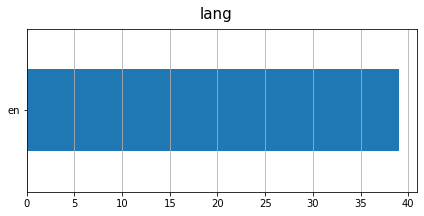

In [82]:

utils_plot_distributions(dtf, x="lang", top=5, figsize=(7,3))

In [84]:
utils_ner_text(dtf["vid_text"].iloc[0], ner, lst_tag_type, grams_join="_")

NameError: ignored

In [86]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [89]:
ner = spacy.load("en_core_web_sm")

In [90]:
lst_tag_type = ["ORG","PERSON","NORP","GPE","LOC","FAC","EVENT","PRODUCT","WORK_OF_ART"]

In [92]:
ner_displacy(dtf["vid_text"].iloc[0], ner, lst_tag_type, title="NER example")

In [93]:
utils_ner_text(dtf["vid_text"].iloc[0], ner, lst_tag_type, grams_join="_")

("- Ah, yes, I remember it\nlike it was yesterday, my big bro, Nacho, and I\ngoing to Ross_Dress for Less and Burlington's Coat_Factory in search of gold. We've always been broke, so we had to find\nalternatives to paying retail. We were on the hunt back then for some of the most hyped shoes on the market. And no, I'm not talking\nabout the_Nike_LunarCharge. What, are you crazy? I'm talkin' about the\nindustry game-changer, the one and only, the_Adidas_Ultraboost. Welcome back to the channel, everybody. If you're new here, my name is Brian, and my Brother, Nacho, and I make videos on sneaker history and all thing related to sneaker culture. So if sneakers are your thing, then please consider\nsubscribing to this channel because we drop videos\nlike this all the time, and you won't wanna miss an upload. All right, guys, with that out of the way, let's get into the video. If you've been paying attention\nto what's been happening in sneaker culture, then\nyou're probably not surprised to 

In [94]:
dtf = add_ner_spacy(dtf, "vid_text", ner, lst_tag_type, grams_join="_", create_features=True)
dtf.head()

--- tagging ---
--- counting tags ---
--- creating features ---


vid_id  ... tags_WORK_OF_ART
0  pH2_IcMSol0  ...                2
1  QYgs5YBWr14  ...                0
2  fVtO4RWRAiw  ...                0
3  aNBP-KQKB2o  ...                1
4  ZOrufstBacY  ...                0

[5 rows x 18 columns]

In [96]:
i = 0
print(dtf["vid_text"].iloc[i], " --> ")
print(dtf["vid_text_tagged"].iloc[i])
print("tags:")
dtf["tags"].iloc[i]

- Ah, yes, I remember it
like it was yesterday, my big bro, Nacho, and I
going to Ross Dress for Less and Burlington's Coat
Factory in search of gold. We've always been broke, so we had to find
alternatives to paying retail. We were on the hunt back then for some of the most hyped shoes on the market. And no, I'm not talking
about the Nike LunarCharge. What, are you crazy? I'm talkin' about the
industry game-changer, the one and only, the Adidas Ultraboost. Welcome back to the channel, everybody. If you're new here, my name is Brian, and my Brother, Nacho, and I make videos on sneaker history and all thing related to sneaker culture. So if sneakers are your thing, then please consider
subscribing to this channel because we drop videos
like this all the time, and you won't wanna miss an upload. All right, guys, with that out of the way, let's get into the video. If you've been paying attention
to what's been happening in sneaker culture, then
you're probably not surprised to learn that 

[{('Adidas', 'PERSON'): 19},
 {('Nike', 'ORG'): 6},
 {('BASF', 'ORG'): 3},
 {('Kanye', 'GPE'): 3},
 {('U.S.', 'GPE'): 3},
 {('German', 'NORP'): 2},
 {('Yeezy', 'PERSON'): 2},
 {('Nacho', 'LOC'): 1},
 {('Ross Dress', 'PERSON'): 1},
 {('Burlington', 'ORG'): 1},
 {('Coat\nFactory', 'FAC'): 1},
 {('the Nike LunarCharge', 'PRODUCT'): 1},
 {('the Adidas Ultraboost', 'ORG'): 1},
 {('Brian', 'PERSON'): 1},
 {('Brother', 'GPE'): 1},
 {('Nacho', 'GPE'): 1},
 {('Boost', 'PERSON'): 1},
 {('Boost', 'NORP'): 1},
 {('NIKE', 'ORG'): 1},
 {('the Energy Boost', 'ORG'): 1},
 {('Dennis Kimetto', 'PERSON'): 1},
 {('Berlin Marathon', 'PERSON'): 1},
 {('the Adidas Pureboost', 'WORK_OF_ART'): 1},
 {('Primeknit', 'ORG'): 1},
 {('Continental', 'NORP'): 1},
 {('David Villa', 'PERSON'): 1},
 {('Yohan Blake', 'PERSON'): 1},
 {("Kanye West's", 'GPE'): 1},
 {('Billboard Awards', 'EVENT'): 1},
 {('Ultraboosts', 'PERSON'): 1},
 {('Stella McCartney', 'PERSON'): 1},
 {('Parley', 'ORG'): 1},
 {('NMD', 'ORG'): 1},
 {('Kanye West', 'GPE'): 1},
 {('Yeezys', 'GPE'): 1},
 {('Adidas', 'GPE'): 1},
 {('Air Jordans', 'ORG'): 1},
 {('VaporMax', 'ORG'): 1},
 {('React', 'PRODUCT'): 1},
 {('the Adidas Deerupt', 'WORK_OF_ART'): 1},
 {('the Adidas Prophere', 'FAC'): 1},
 {('Nike M2Ks', 'PRODUCT'): 1},
 {('Yeezys', 'PERSON'): 1},
 {('American', 'NORP'): 1},
 {('the Adidas Stan Smith', 'FAC'): 1},
 {('the Adidas Superstar', 'FAC'): 1}]

# TheRiseandFallofAdidasBoost-WhatHappened-pH2_IcMSol0.en.csv:


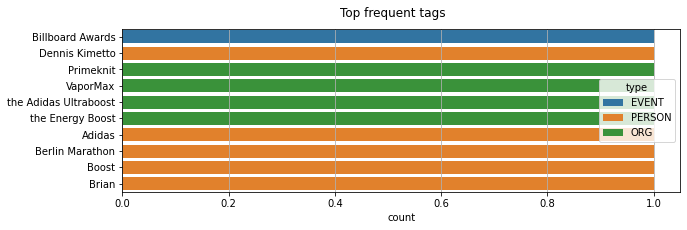

# What'sinsideAdidasBoostBall-QYgs5YBWr14.en.csv:


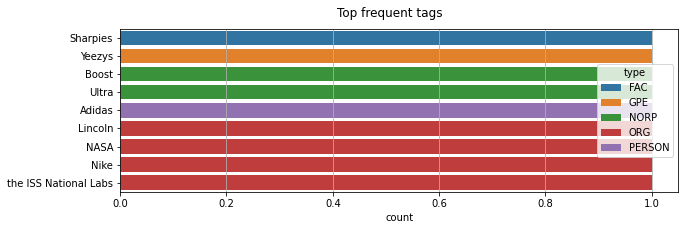

# NikeEpicReactvsAdidasUltraBoost-TheTruth!-fVtO4RWRAiw.en.csv:


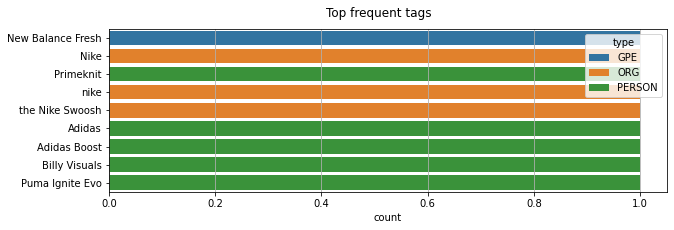

# AdidasUltraBoost20(ISS)_Unboxing&OnFootReview-aNBP-KQKB2o.en.csv:


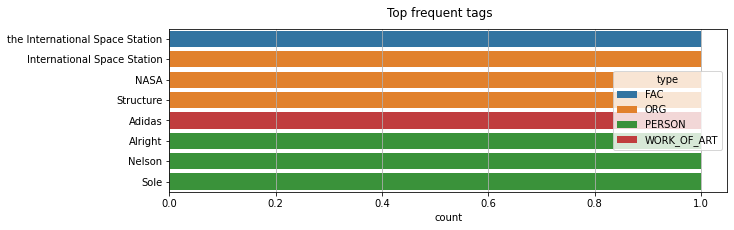

# ADIDASULTRABOOSTSUMMER.RDY-UNBOXING-TEST0_16KM_H-ZOrufstBacY.en.csv:


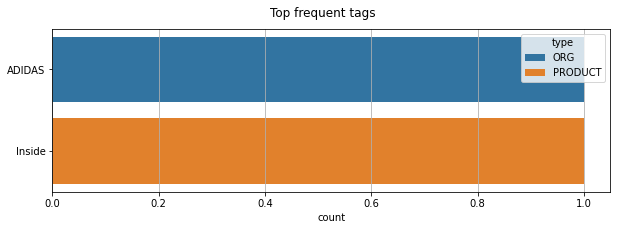

# ACTIONBRONSONADIDASULTRABOOST(RARELOOK)-y_qfu921a1o.en.csv:


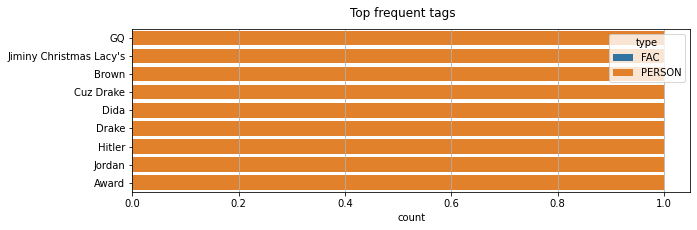

# adidasultraBOOSTXRunningShoeReview-vAITOCyFzhc.en.csv:


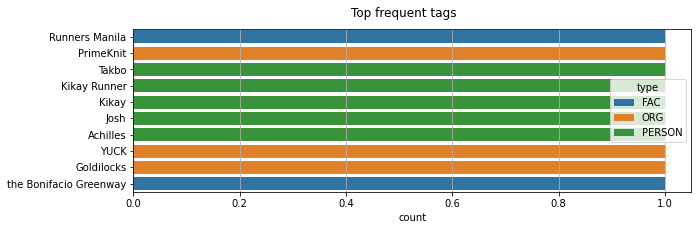

# 500MilesTest-AdidasALPHABOUNCEisbetterthanULTRABOOST1.0TheBestshoefortravelling--xJfo-0wPzE.en.csv:


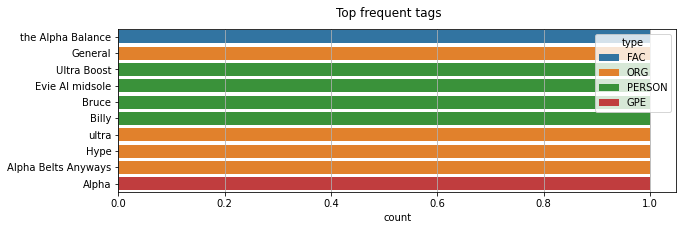

# TheGarage–PerfectGripwithadidasandContinental-5eMEOsEv-VQ.en.csv:


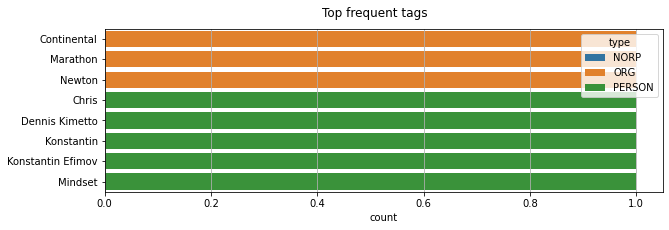

# AdidasUltraboost1.0OG_Review+On-Feet_AFEWSTORE(GreatestRunningShoeever)-CsUciHZEM5E.en.csv:


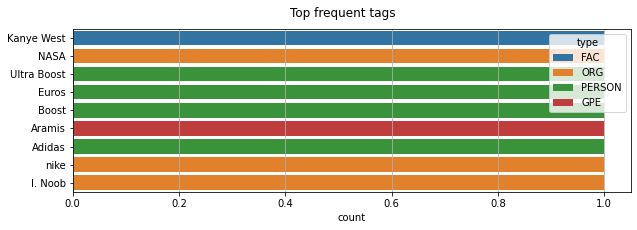

# AdidasUltraBOOSTUncaged+GiveawayHint_UnbXingEp.02(ENGSUBS)-sMCu6g3MbB4.en.csv:


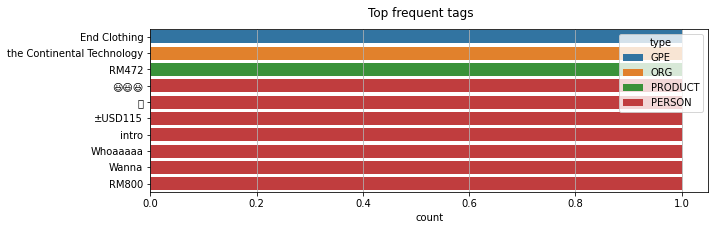

# AdidasUltraBOOSTXATRReview-RUKAjnA11H8.en.csv:


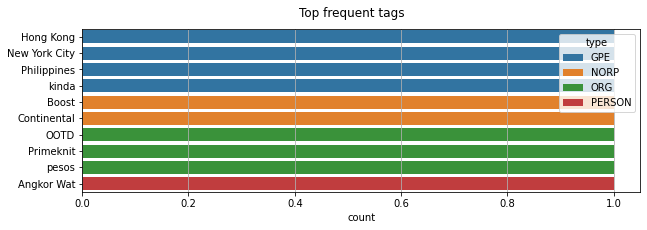

# UltraBoost3.0Try-OnandReview_AreTheyWorthIt-FuxGiSUzvnc.en.csv:


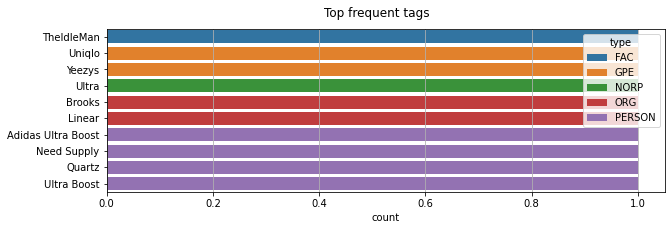

# StylingtheAdidasUltraBoost19(Unboxing,On-feetReview,SneakerLookbook)-ErZ3AjBLCfw.en.csv:


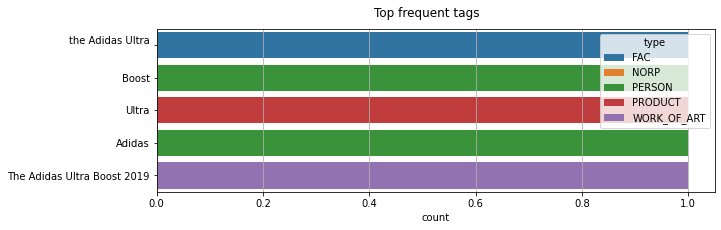

# AdidasUltraBoostSneakerExchangebySNSSneakersnstuffandSocialStatusReviewandOnFeet-yoQlNVTTifw.en.csv:


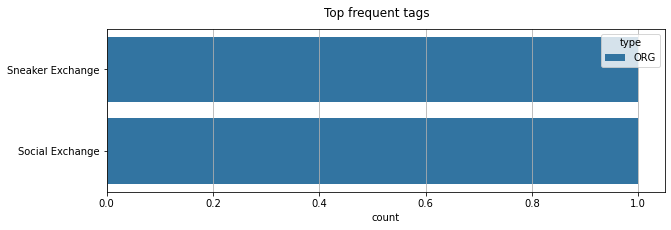

# adidasHaul我賺的錢通通還給愛迪達了😂｜Jasmine-TihgNApuLgE.en.csv:


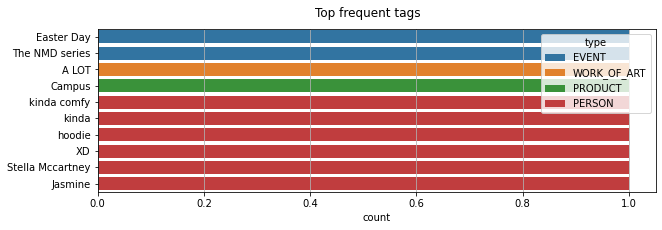

# 574Sport,KeepingAdidasOntheirToes,NewBalanceFreshFoam574sBredEdition-T26XJdbkyU4.en.csv:


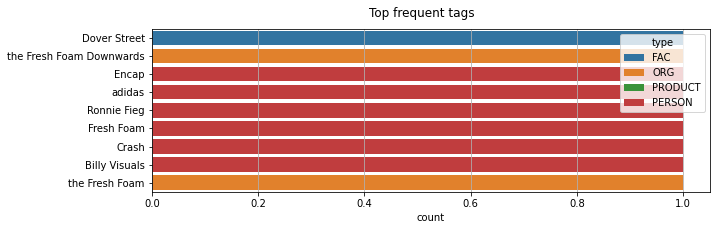

# SNKRS-AdidasUltraBoostUncaged(EngSub)-XOdmzsmRDTE.en.csv:


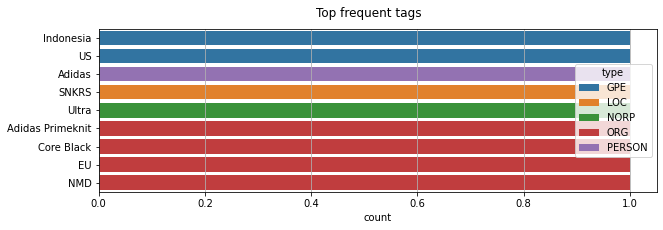

# What'sinsideYeezys-7tq482HMX78.en.csv:


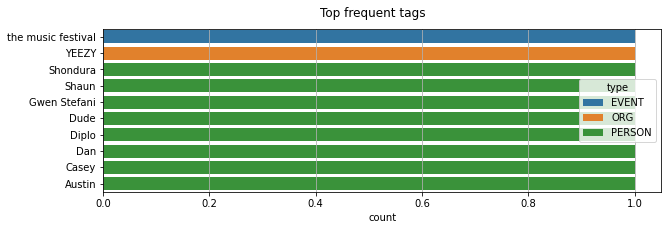

# AdidasUltraBoostSolarYellow_White(KanyeWest)comparison+review+unboxing+on-feet-8XITZ08NqSU.en.csv:


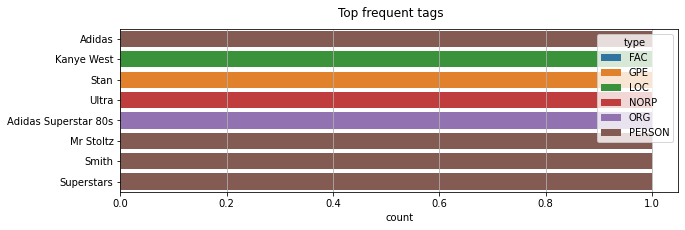

# [REVIEW]ADIDASULTRABOOST_Valelapenatodavia-R61Ahh5lDH8.en.csv:


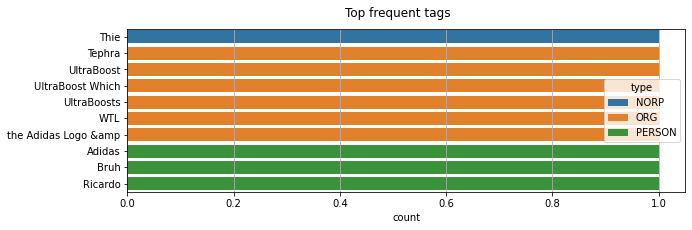

# [ENG]아디다스울트라부스트19블랙,AdidasUltraBoost19Black-fLNKYx-A_1Y.en.csv:


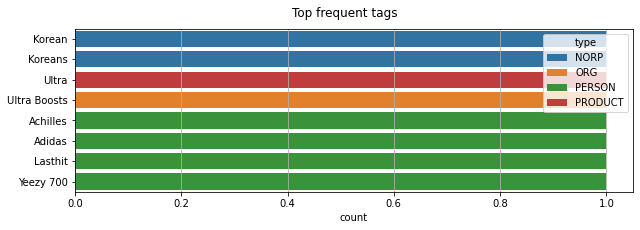

# 아디다스울부희귀템모아봄!울트라부스트콜라보신발리뷰(+무신사한정판)-PcCs6pQ1iFk.en.csv:


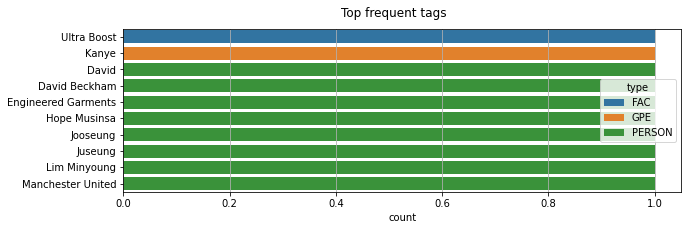

# IsAdiPRENE+BetterthanBOOSTYeezy500vsYeezy350V2ComfortComparison-B8OZxgUHiho.en.csv:


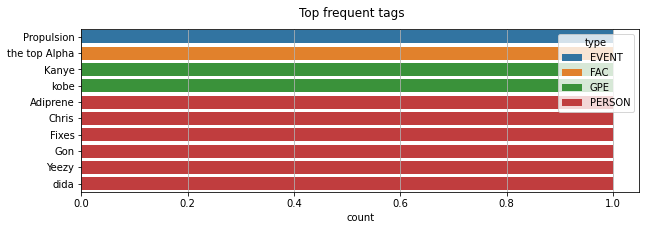

# ADIDASULTRABOOSTCREAM2018(RESTOCK)_REVIEW&ON-FEET-M46TFlKimYs.en.csv:


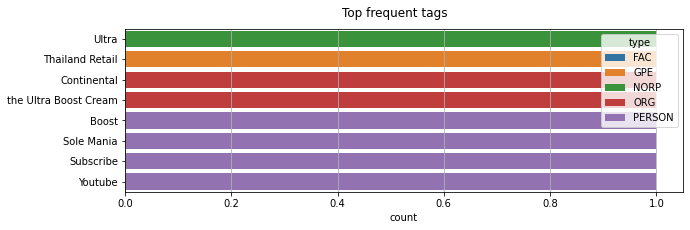

# Women'sAdidasUltraBoostReview-psRIdqkpAOI.en.csv:


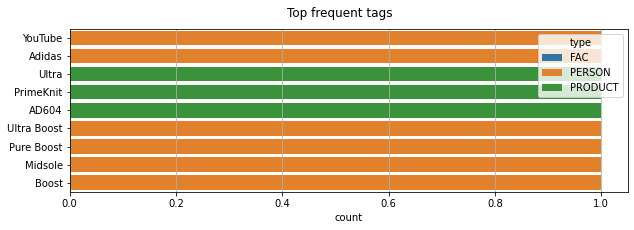

# UndefeatedUltraBoostCustombyVickAlmighty-gvJsNCf5ogo.en.csv:


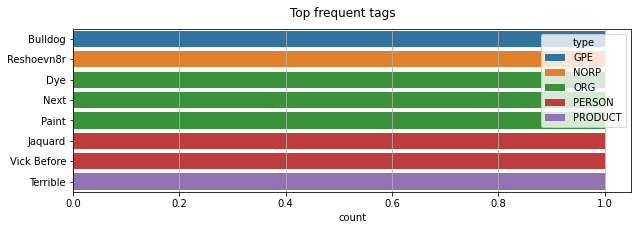

# StylingtheAdidasUltraBoostGoldMedal2.0(Unboxing,On-feetReview,SneakerLookbook)-32BvpSVvPMw.en.csv:


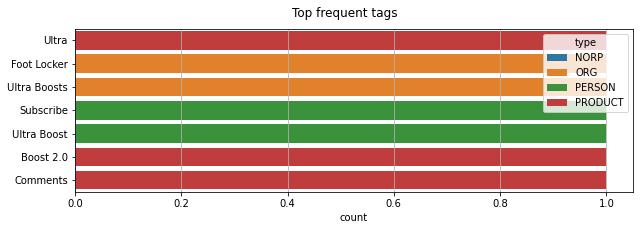

# HowToPinrollYourPantsFt.TripleWhiteUltraBoostOnFeet+GIVEAWAY!!!!-CPtfs1uZwew.en.csv:


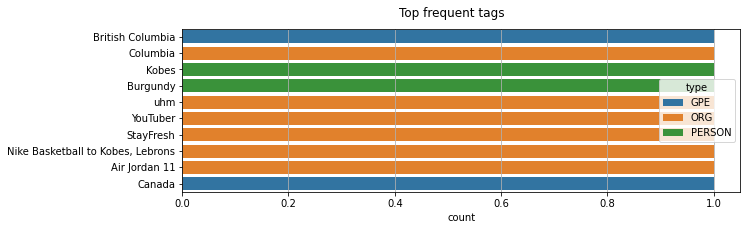

# TieDyeYourShoesAtHome(EASYDIY)-zYMbCJZljsw.en.csv:


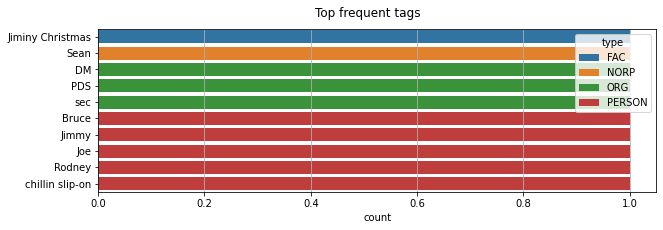

# Review#2SoleboxXAdidasUltraboostyreshapedeAirmax1SafariQSporKHORDĒ+englishsubs-bStgH_OA0A8.en.csv:


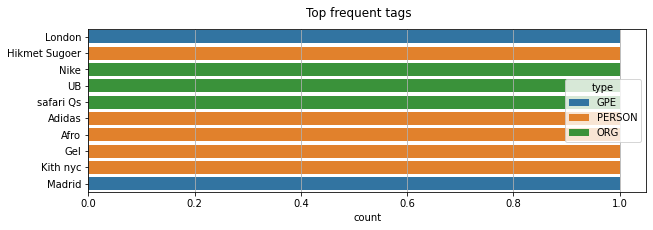

# 2ndUltraBOOSTLacelessintheOreocolorway.OrisitMulticolorA+16PurecontrolUltraboost-t0ix1aFp2K4.en.csv:


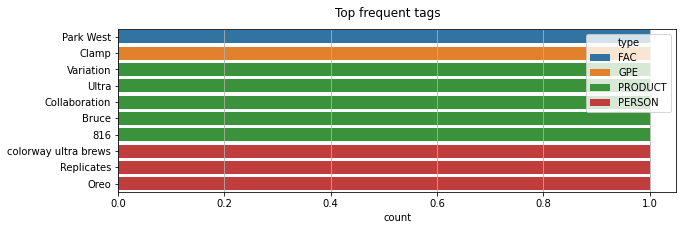

# 為什麼ultraboost這麼貴馬牌又是什麼｜EvinisChen-3_hHaceDVHA.en.csv:


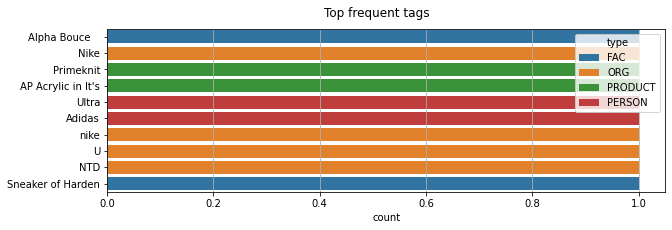

# HowtoSourceAdidasSneakerstoResellforaProfit-ABAO3xaiOWQ.en.csv:


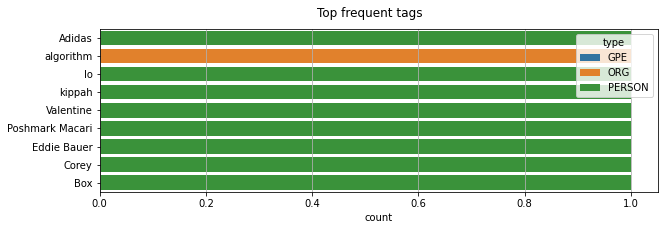

# StockXMKTWatch-UltraBoostTakestheThrone,SupremeCallsAction,andAirMaxOut-bgwyK50CmnA.en.csv:


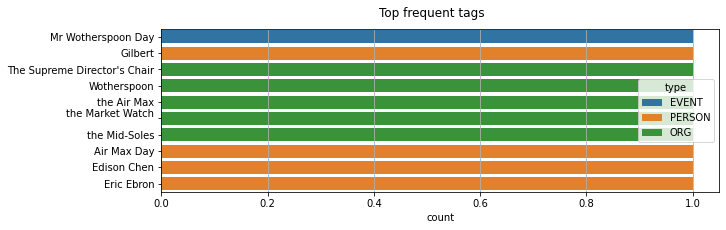

# AdidasxGameOfThronesHouseStarkUltraBoostCollabUnbox-KXCFkGTBKS0.en.csv:


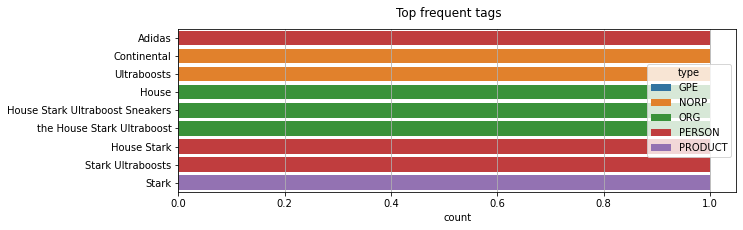

# RecensioneULTRABOOSTdelFAKEMARKET-wXJ6V4XBGTI.en.csv:


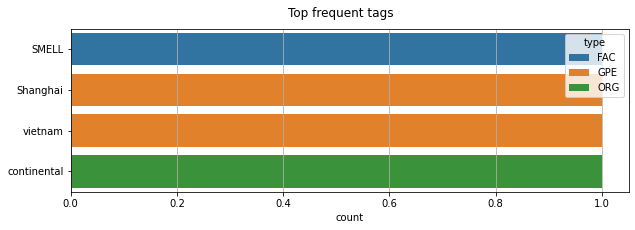

# FoundUltraboostforretailbahasaIndonesia(EnglishSubs)-tSnIj-qhe1M.en.csv:


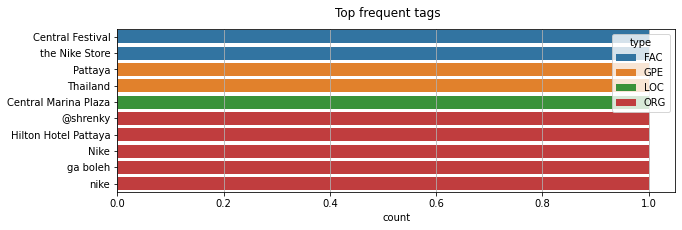

# AdidasTour360XTPrimeknitGolfShoesreview-ThenewestAdidasGolfShoes-JIavzgivHyM.en.csv:


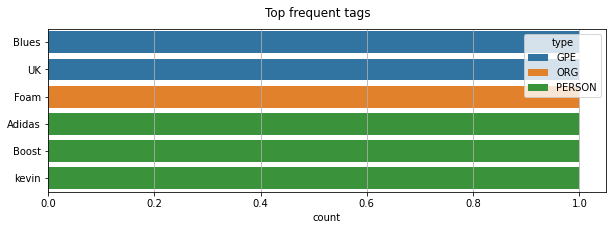

In [100]:
for vid_title in dtf["vid_title"].unique():
    print("# {}:".format(vid_title))
    common_tags = tags_freq(tags=dtf[dtf["vid_title"]==vid_title]["tags"], top=10, figsize=(10,3))

In [ ]:
# tags bivariate distribution
for x in dtf.filter(like="tags_", axis=1).columns:
    utils_plot_distributions(dtf, x=x, y="vid_text", bins=None, figsize=(15,5))

In [108]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [109]:
i = 0
print("--- original ---")
print(dtf["vid_text"].iloc[i])

print("--- cleaning ---")
print(utils_preprocess_text(dtf["vid_text"].iloc[i], lst_regex=None, 
                      lst_stopwords=None, flg_stemm=False, flg_lemm=True))

print("--- tokenization ---")
print(dtf["vid_text"].iloc[i].split())

print("--- remove stopwords ---")
print(utils_preprocess_text(dtf["vid_text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      flg_stemm=False, flg_lemm=None))

print("--- stemming ---")
print(utils_preprocess_text(dtf["vid_text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      flg_stemm=True, flg_lemm=False))

print("--- lemmatisation ---")
print(utils_preprocess_text(dtf["vid_text"].iloc[i], lst_regex=None, 
                      lst_stopwords=nltk.corpus.stopwords.words("english"), 
                      flg_stemm=False, flg_lemm=True))

--- original ---
- Ah, yes, I remember it
like it was yesterday, my big bro, Nacho, and I
going to Ross Dress for Less and Burlington's Coat
Factory in search of gold. We've always been broke, so we had to find
alternatives to paying retail. We were on the hunt back then for some of the most hyped shoes on the market. And no, I'm not talking
about the Nike LunarCharge. What, are you crazy? I'm talkin' about the
industry game-changer, the one and only, the Adidas Ultraboost. Welcome back to the channel, everybody. If you're new here, my name is Brian, and my Brother, Nacho, and I make videos on sneaker history and all thing related to sneaker culture. So if sneakers are your thing, then please consider
subscribing to this channel because we drop videos
like this all the time, and you won't wanna miss an upload. All right, guys, with that out of the way, let's get into the video. If you've been paying attention
to what's been happening in sneaker culture, then
you're probably not surpris

In [110]:
lst_stopwords = create_stopwords(["english"], 
                                 lst_add_words=["dtype","say","new","length","object","u","ha","wa"],
                                 lst_keep_words=["new"])
lst_stopwords


['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'dtype',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'ha',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'length',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'object',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'say',
 'shan',
 "shan't",
 'she',
 "she's",
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'u',
 'under',
 'until',
 'up',
 've',
 'very',
 'wa',
 'was',
 'wasn',
 "wasn't",
 'we',
 'were',
 'weren',
 "weren't",
 'what',
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'will',
 'with',
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 'y',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'your',
 'yours',
 'yourself',
 'yourselves']

In [111]:
dtf = add_preprocessed_text(dtf, "vid_text", lst_regex=None, lst_stopwords=lst_stopwords, flg_stemm=False, flg_lemm=True)
dtf.head()

vid_id  ...                                     vid_text_clean
0  pH2_IcMSol0  ...  ah yes remember like yesterday big bro nacho g...
1  QYgs5YBWr14  ...  sharp knife rubber boost ball oh goodness upbe...
2  fVtO4RWRAiw  ...  first prop nike sneaker company finally realiz...
3  aNBP-KQKB2o  ...  going guy welcome back channel boy nelson anot...
4  ZOrufstBacY  ...  theyre finally ive waiting 2 week couldnt hand...

[5 rows x 19 columns]

In [112]:
i = 0
print(dtf["vid_text"].iloc[i], " --> ")
print(dtf["vid_text_clean"].iloc[i])

- Ah, yes, I remember it
like it was yesterday, my big bro, Nacho, and I
going to Ross Dress for Less and Burlington's Coat
Factory in search of gold. We've always been broke, so we had to find
alternatives to paying retail. We were on the hunt back then for some of the most hyped shoes on the market. And no, I'm not talking
about the Nike LunarCharge. What, are you crazy? I'm talkin' about the
industry game-changer, the one and only, the Adidas Ultraboost. Welcome back to the channel, everybody. If you're new here, my name is Brian, and my Brother, Nacho, and I make videos on sneaker history and all thing related to sneaker culture. So if sneakers are your thing, then please consider
subscribing to this channel because we drop videos
like this all the time, and you won't wanna miss an upload. All right, guys, with that out of the way, let's get into the video. If you've been paying attention
to what's been happening in sneaker culture, then
you're probably not surprised to learn that 

In [113]:
dtf = add_text_length(dtf, "vid_text_clean")
dtf.head()

                           min         mean           max
word_count            8.000000   580.384615   2019.000000
char_count           47.000000  3087.897436  10503.000000
sentence_count        1.000000     1.000000      1.000000
avg_word_length       4.698679     5.338657      6.045961
avg_sentence_lenght   8.000000   580.384615   2019.000000


vid_id  ... avg_sentence_lenght
0  pH2_IcMSol0  ...               718.0
1  QYgs5YBWr14  ...               630.0
2  fVtO4RWRAiw  ...               796.0
3  aNBP-KQKB2o  ...               484.0
4  ZOrufstBacY  ...                87.0

[5 rows x 24 columns]

In [114]:
# check
i = 0
print(dtf["vid_text_clean"].iloc[i], " --> ")
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    print(col+":", dtf[col].iloc[i])


ah yes remember like yesterday big bro nacho going ross dress le burlington coat factory search gold weve always broke find alternative paying retail hunt back hyped shoe market im talking nike lunarcharge crazy im talkin industry gamechanger one adidas ultraboost welcome back channel everybody youre new name brian brother nacho make video sneaker history thing related sneaker culture sneaker thing please consider subscribing channel drop video like time wont wanna miss upload right guy way let get video youve paying attention whats happening sneaker culture youre probably surprised learn adidas boost line lost cultural impact relevance lost hype mean take look latest offering adidas ultraboost 20 uninspired tired gimmicky thats brand dont make cringeworthy sneaker time thats also boostequipped adidas arent comfortable bestperforming sneaker bless foot multitude reason boost isnt popular could first let get little history back 2007 german chemical company basf developed new technology 

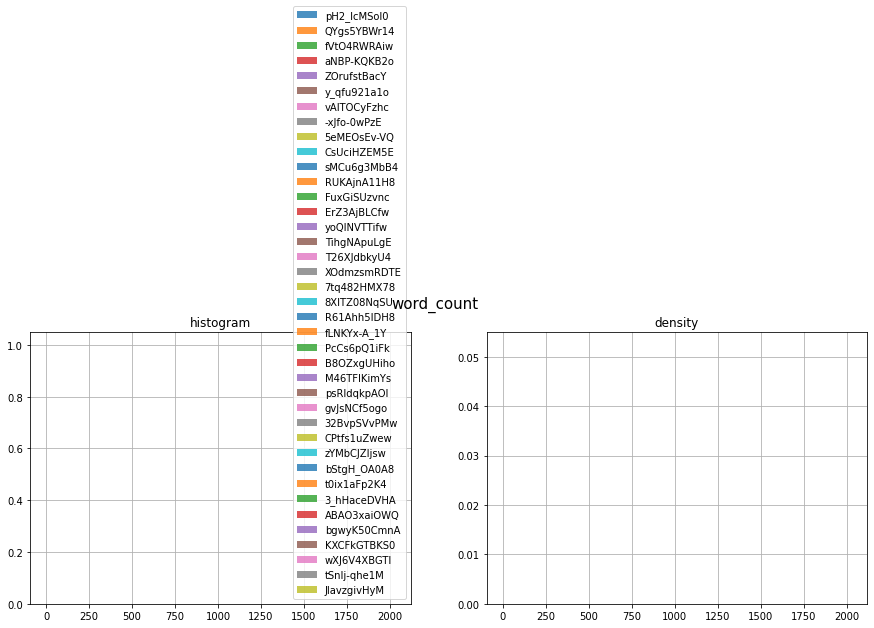

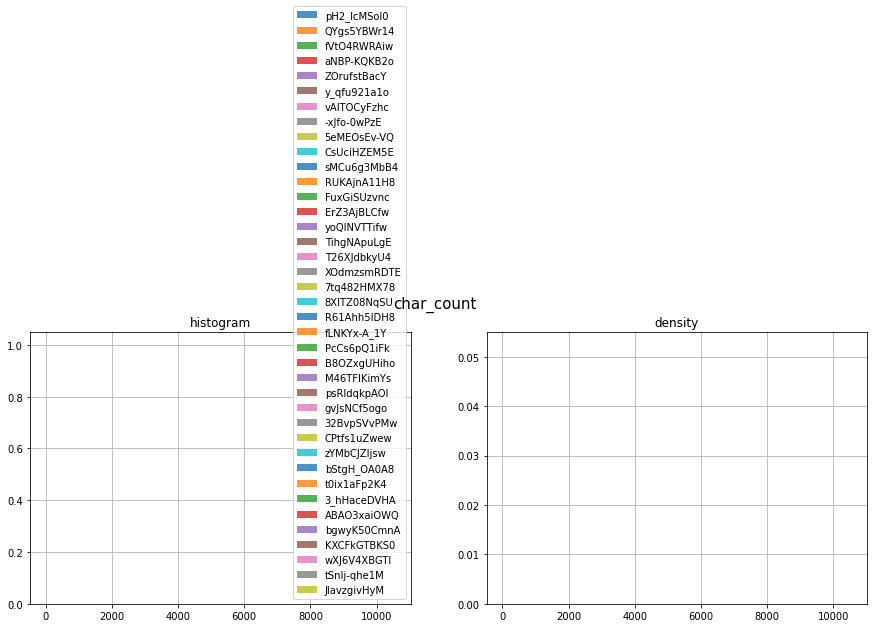

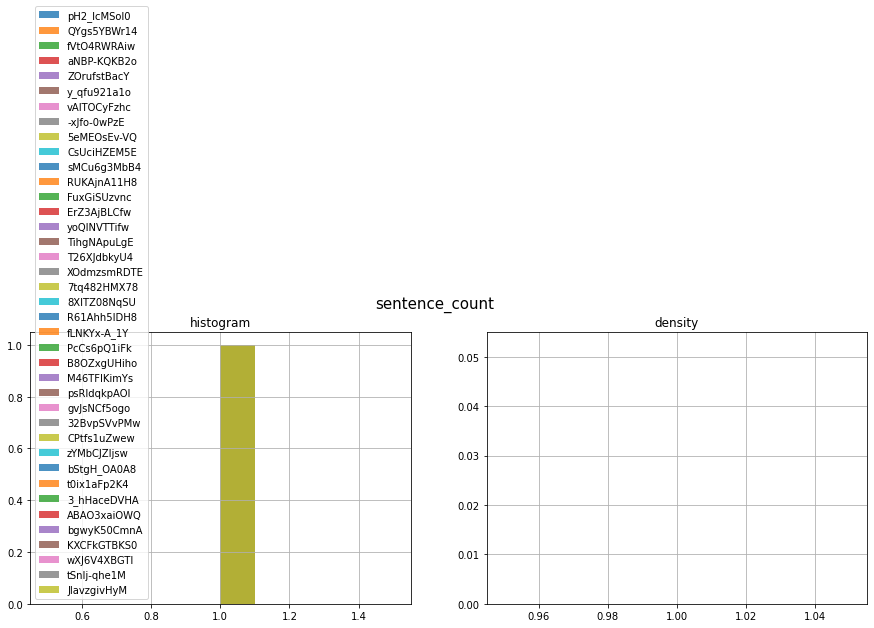

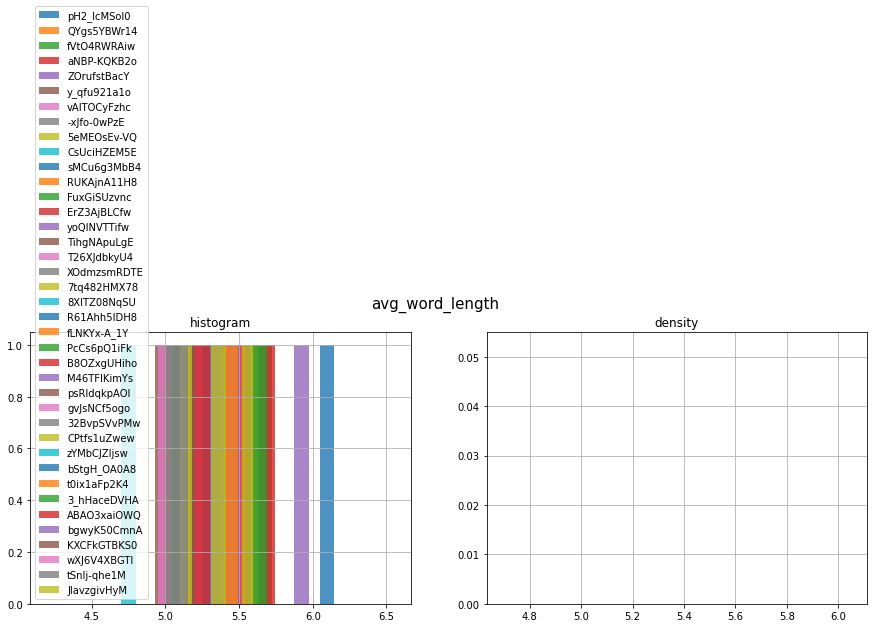

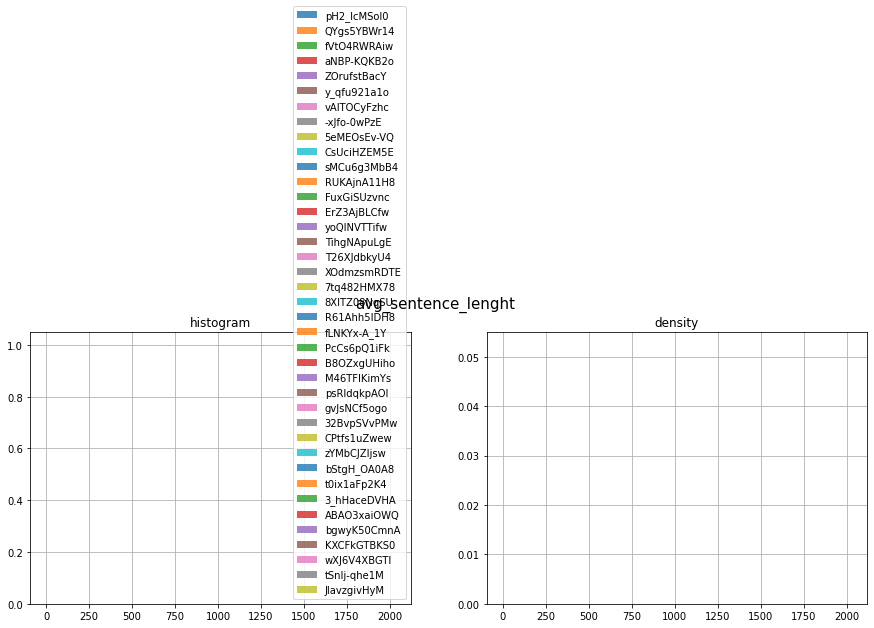

In [115]:
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    utils_plot_distributions(dtf, x=col, y="vid_id", bins=10, figsize=(15,5))

In [116]:
dtf = add_sentiment(dtf, "vid_text_clean", algo="textblob", sentiment_range=(-1,1))
dtf.head()

           count      mean       std  ...       50%      75%       max
sentiment   39.0  0.138009  0.106912  ...  0.155153  0.17968  0.258937

[1 rows x 8 columns]


vid_id  ... sentiment
0  pH2_IcMSol0  ...  0.126037
1  QYgs5YBWr14  ...  0.158483
2  fVtO4RWRAiw  ...  0.056928
3  aNBP-KQKB2o  ...  0.178995
4  ZOrufstBacY  ...  0.152189

[5 rows x 25 columns]

In [117]:
# check
i = 0
print(dtf["vid_text"].iloc[i], " --> ", dtf["sentiment"].iloc[i])

- Ah, yes, I remember it
like it was yesterday, my big bro, Nacho, and I
going to Ross Dress for Less and Burlington's Coat
Factory in search of gold. We've always been broke, so we had to find
alternatives to paying retail. We were on the hunt back then for some of the most hyped shoes on the market. And no, I'm not talking
about the Nike LunarCharge. What, are you crazy? I'm talkin' about the
industry game-changer, the one and only, the Adidas Ultraboost. Welcome back to the channel, everybody. If you're new here, my name is Brian, and my Brother, Nacho, and I make videos on sneaker history and all thing related to sneaker culture. So if sneakers are your thing, then please consider
subscribing to this channel because we drop videos
like this all the time, and you won't wanna miss an upload. All right, guys, with that out of the way, let's get into the video. If you've been paying attention
to what's been happening in sneaker culture, then
you're probably not surprised to learn that 

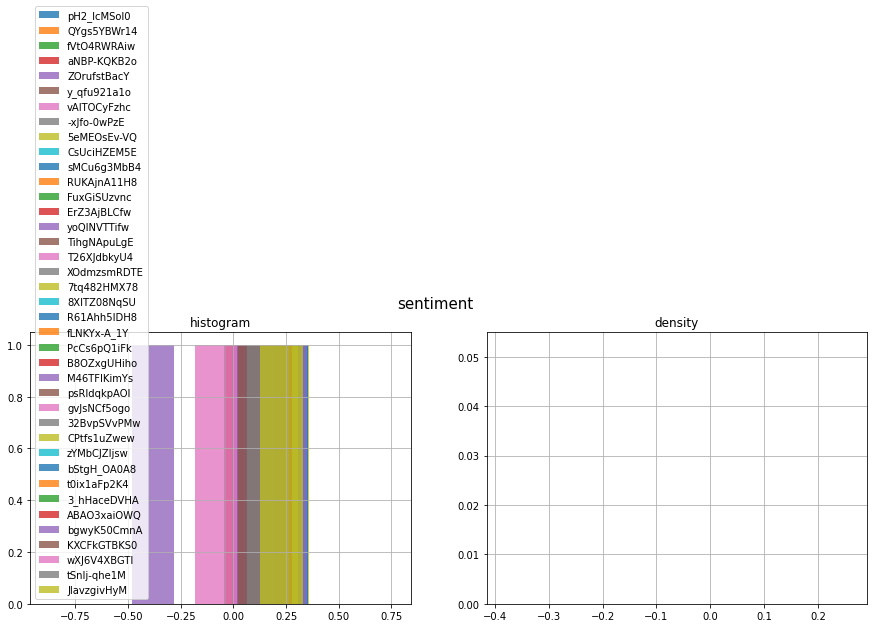

In [118]:
utils_plot_distributions(dtf, x="sentiment", y="vid_id", bins=5, figsize=(15,5))

In [120]:
# I'll give a range of 0-1 to the sentiment
dtf = add_sentiment(dtf, "vid_text_clean", algo="textblob", sentiment_range=(0,1))

           count      mean      std  min       25%      50%       75%  max
sentiment   39.0  0.811718  0.16646  0.0  0.776331  0.83841  0.876599  1.0


In [122]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# pH2_IcMSol0:


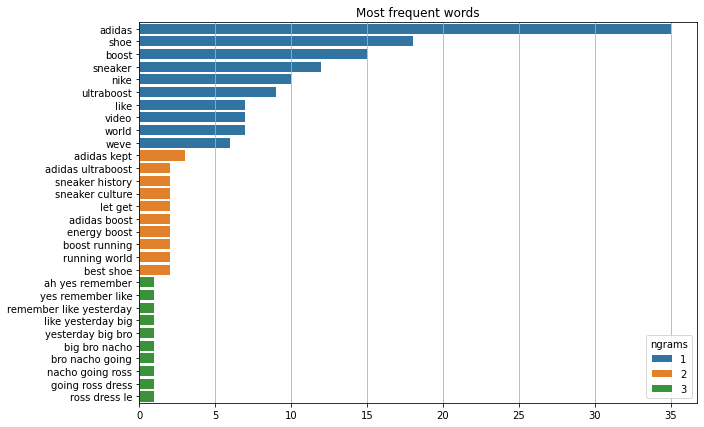

# QYgs5YBWr14:


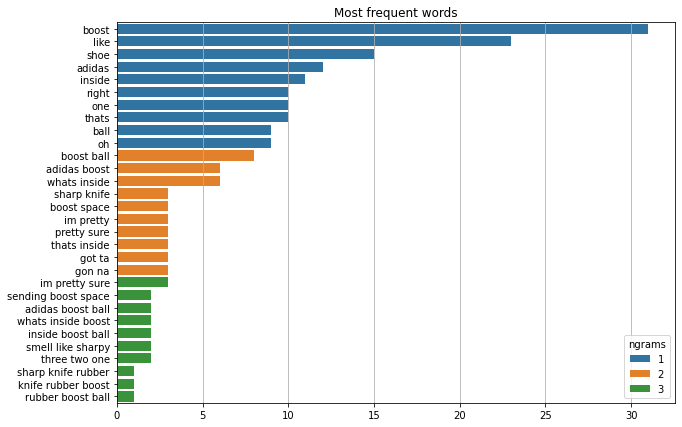

# fVtO4RWRAiw:


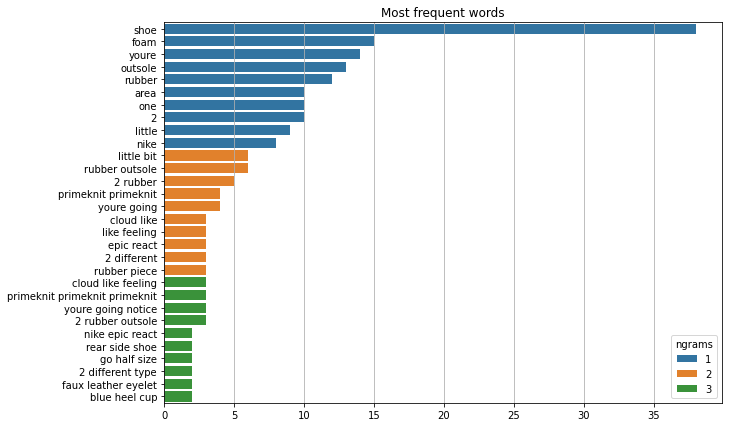

# aNBP-KQKB2o:


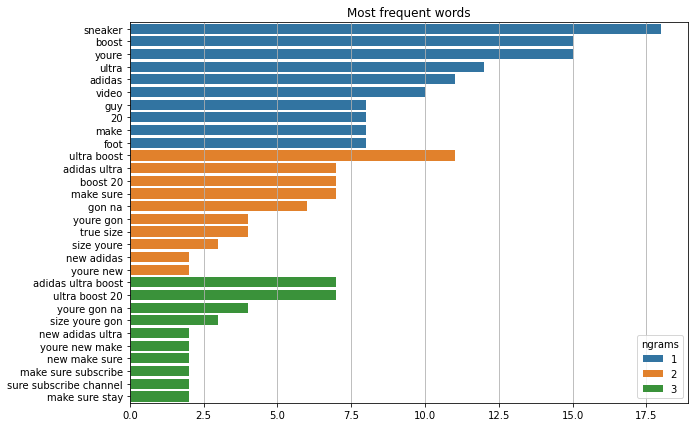

# ZOrufstBacY:


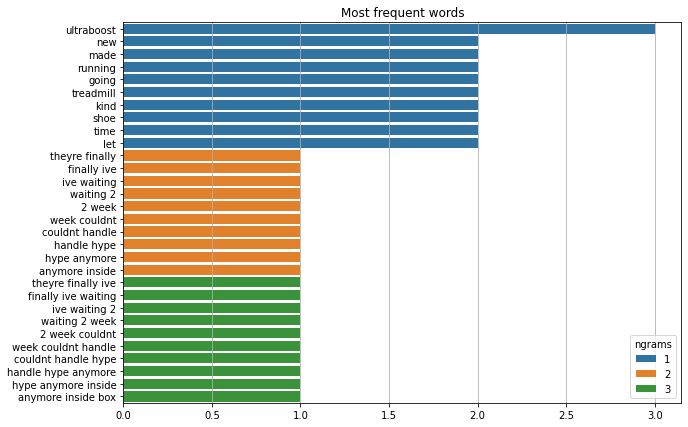

# y_qfu921a1o:


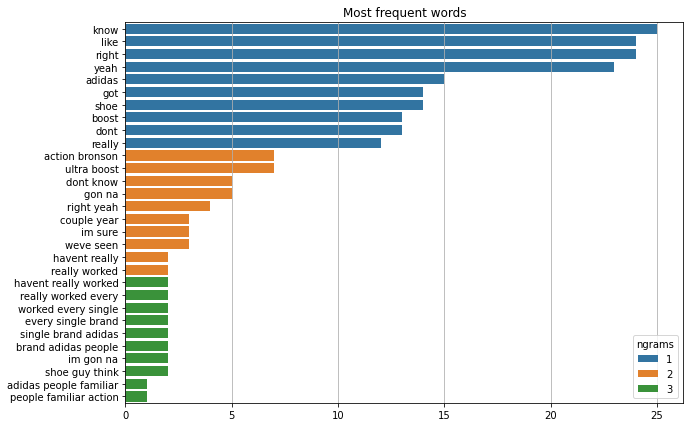

# vAITOCyFzhc:


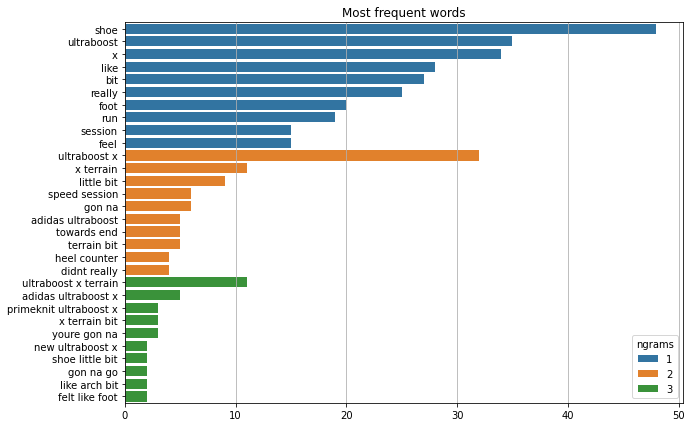

# -xJfo-0wPzE:


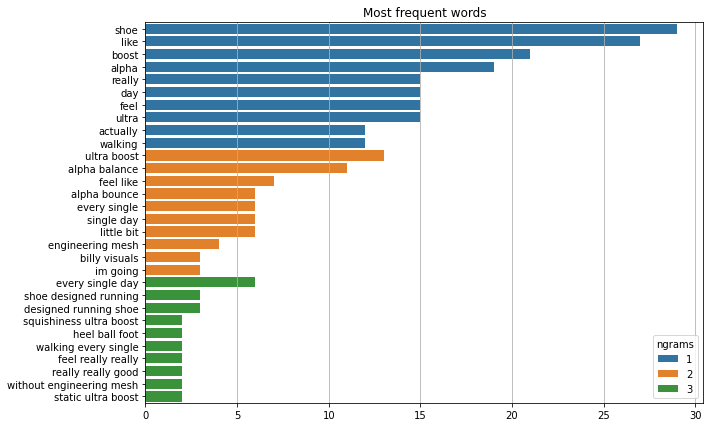

# 5eMEOsEv-VQ:


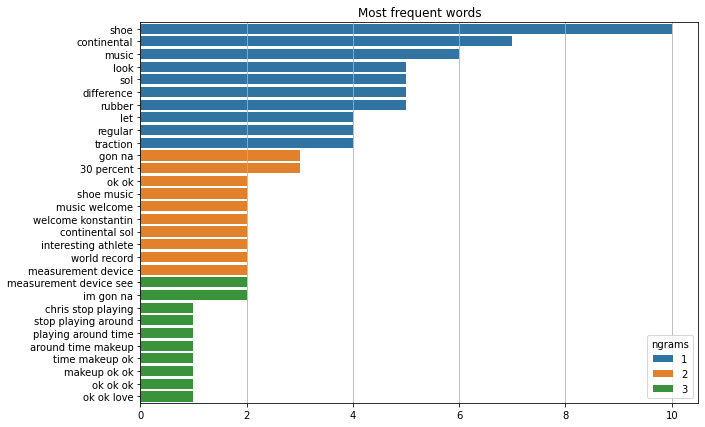

# CsUciHZEM5E:


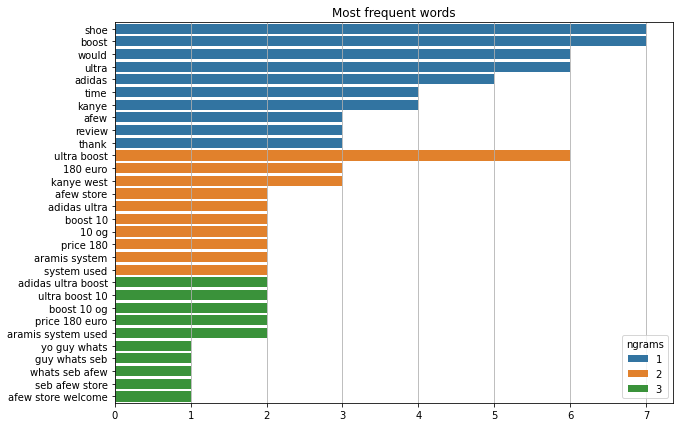

# sMCu6g3MbB4:


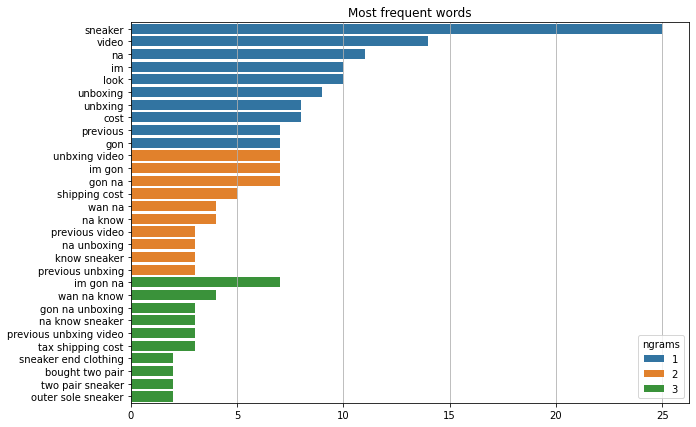

# RUKAjnA11H8:


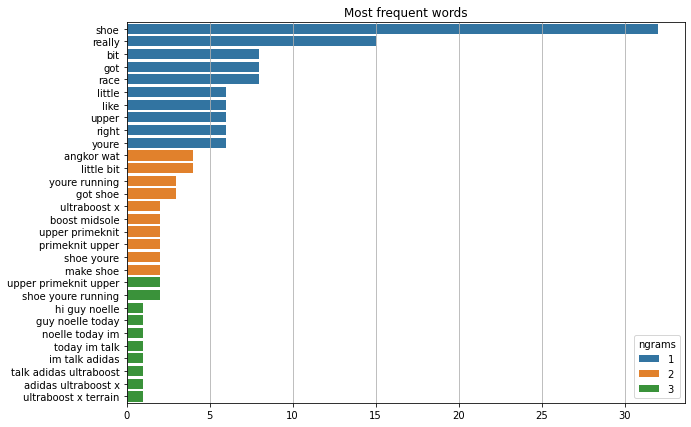

# FuxGiSUzvnc:


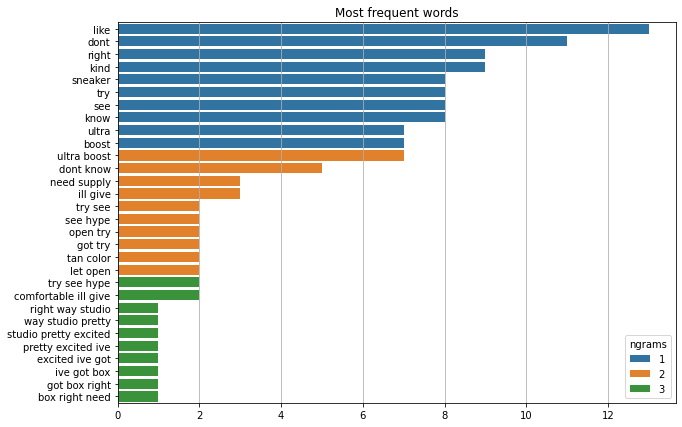

# ErZ3AjBLCfw:


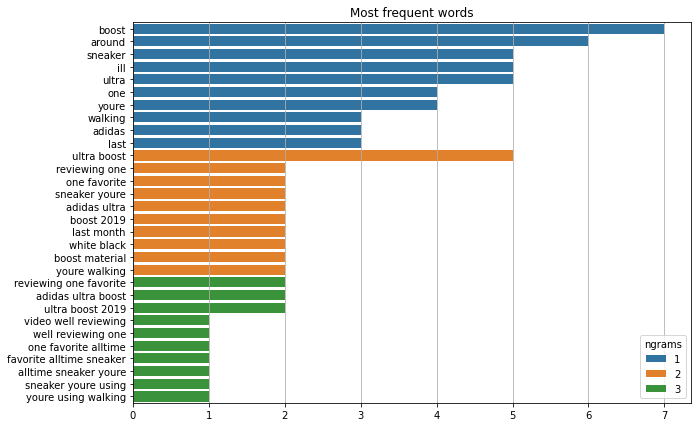

# yoQlNVTTifw:


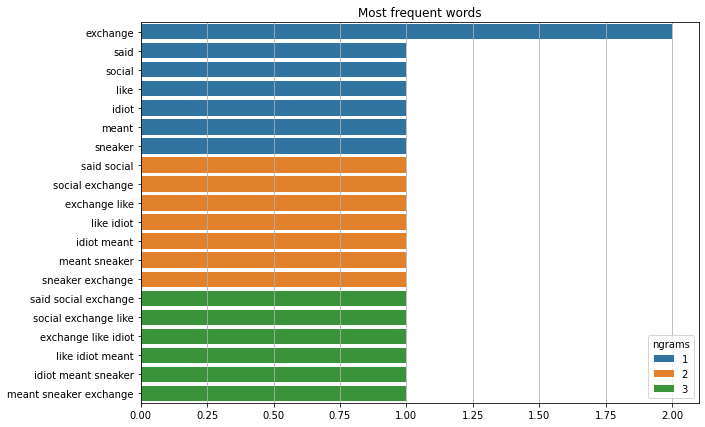

# TihgNApuLgE:


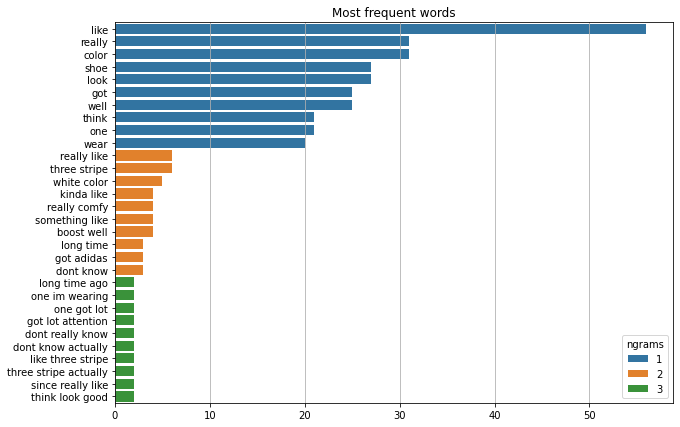

# T26XJdbkyU4:


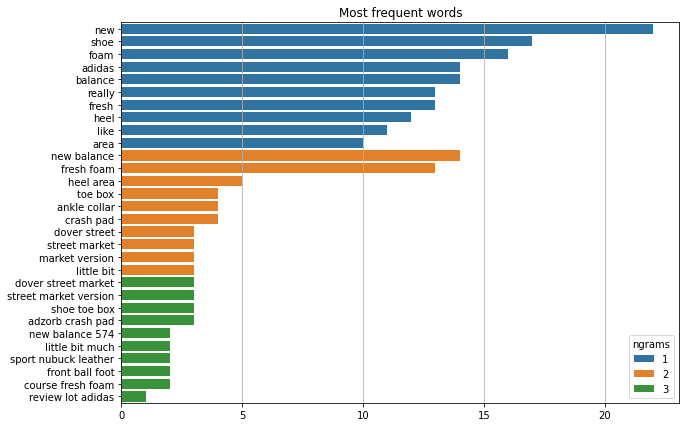

# XOdmzsmRDTE:


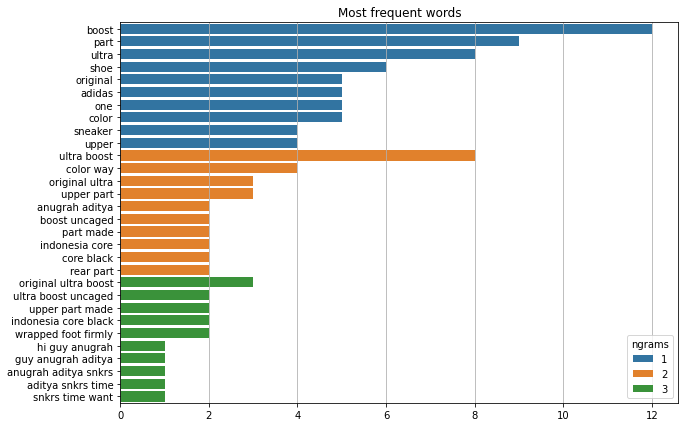

# 7tq482HMX78:


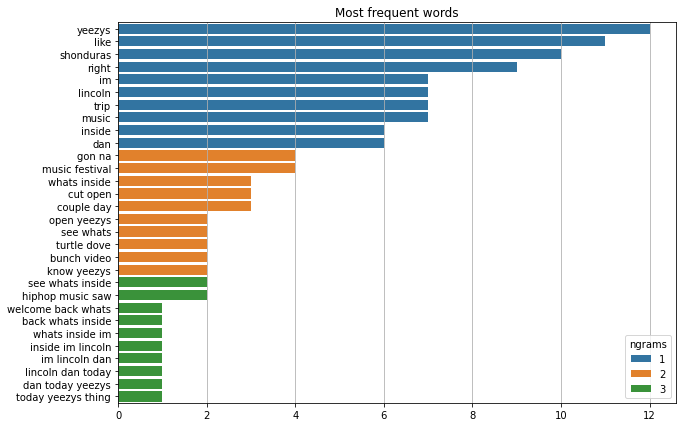

# 8XITZ08NqSU:


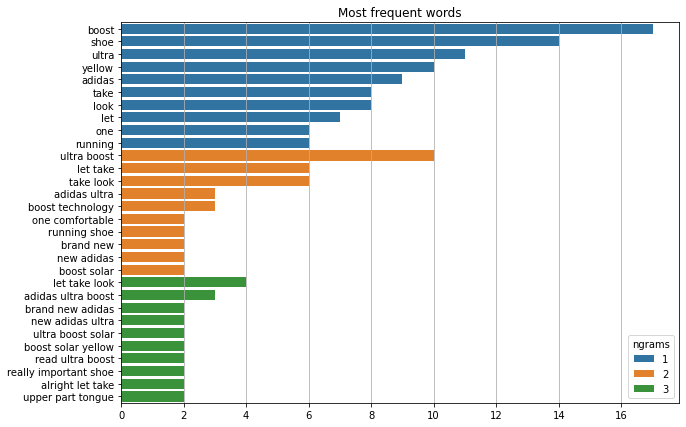

# R61Ahh5lDH8:


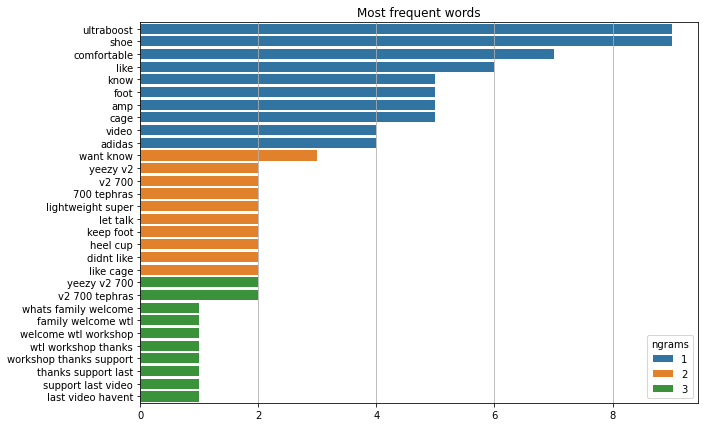

# fLNKYx-A_1Y:


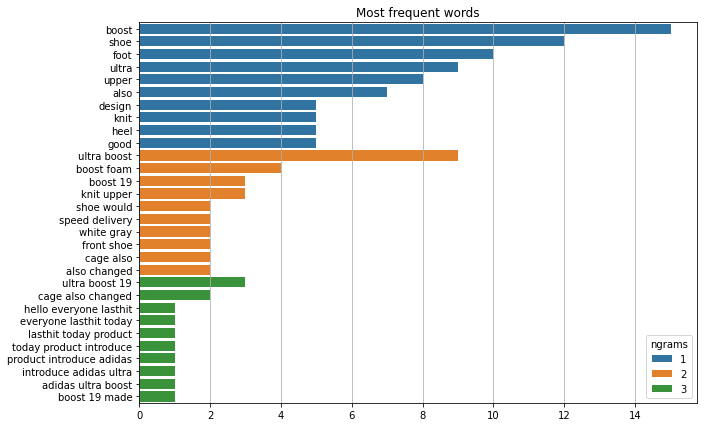

# PcCs6pQ1iFk:


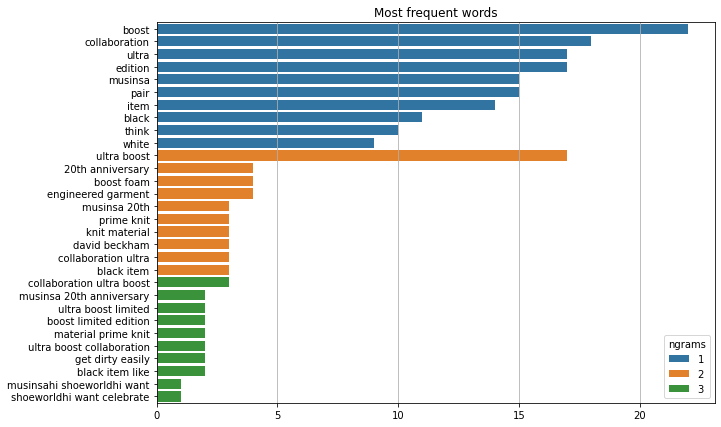

# B8OZxgUHiho:


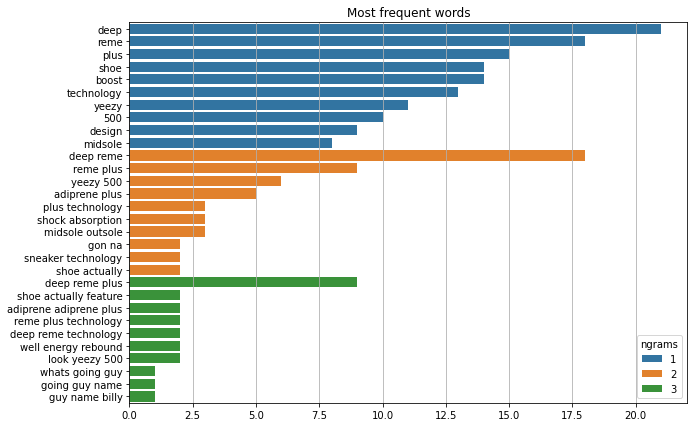

# M46TFlKimYs:


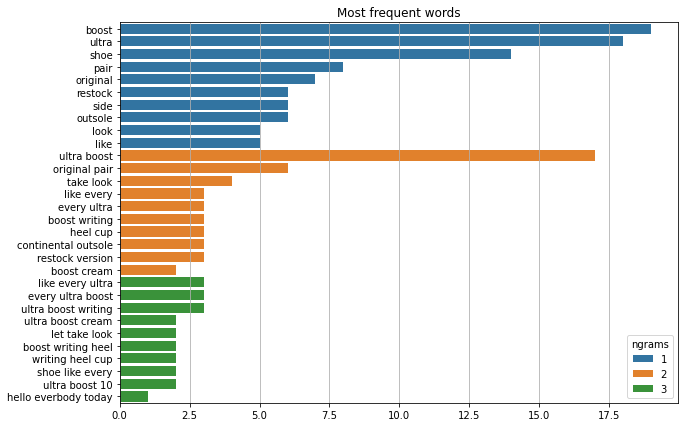

# psRIdqkpAOI:


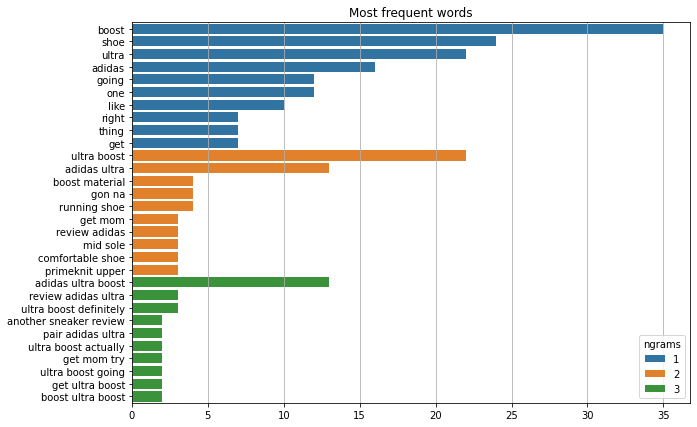

# gvJsNCf5ogo:


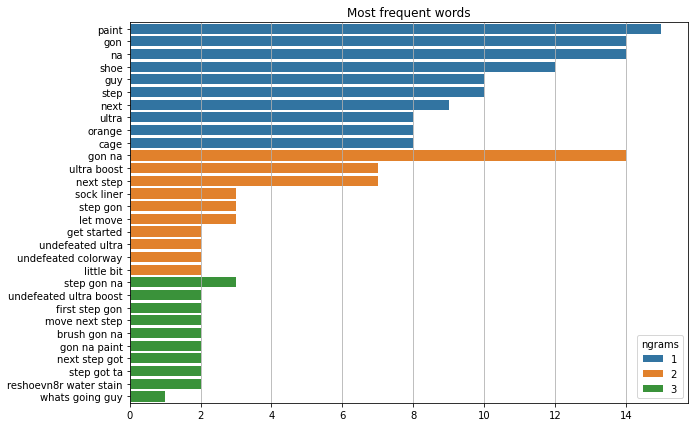

# 32BvpSVvPMw:


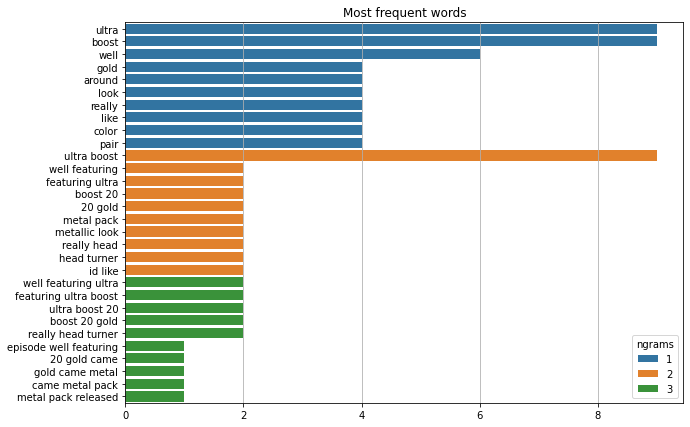

# CPtfs1uZwew:


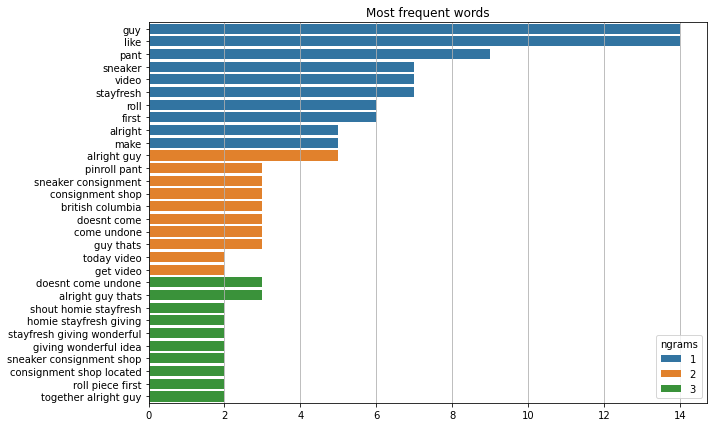

# zYMbCJZljsw:


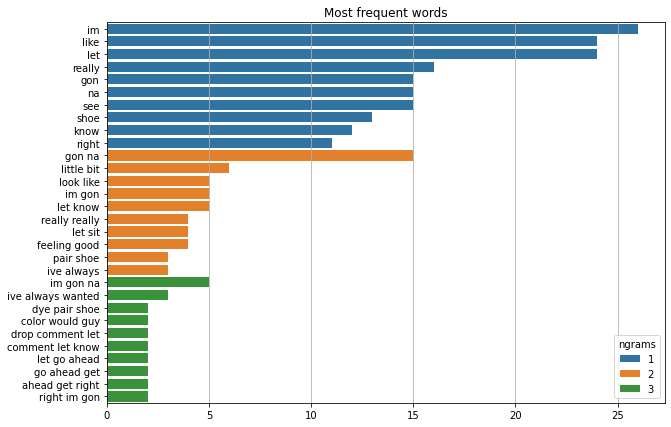

# bStgH_OA0A8:


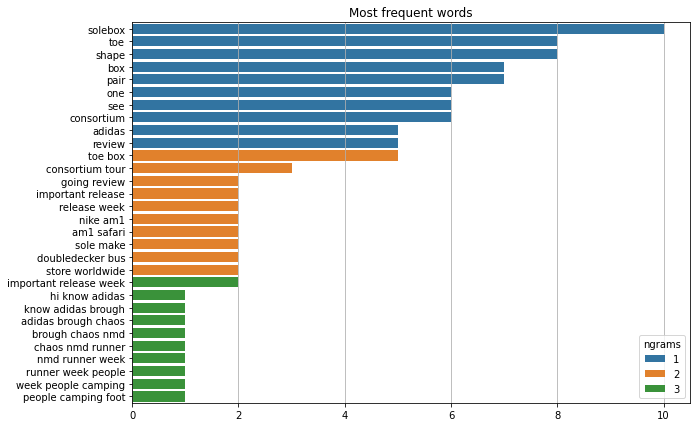

# t0ix1aFp2K4:


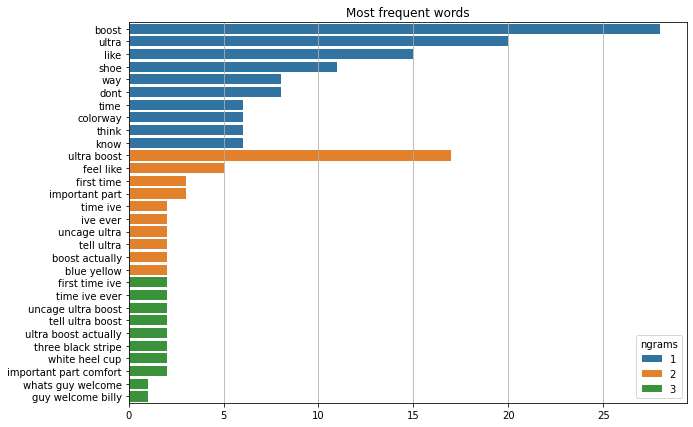

# 3_hHaceDVHA:


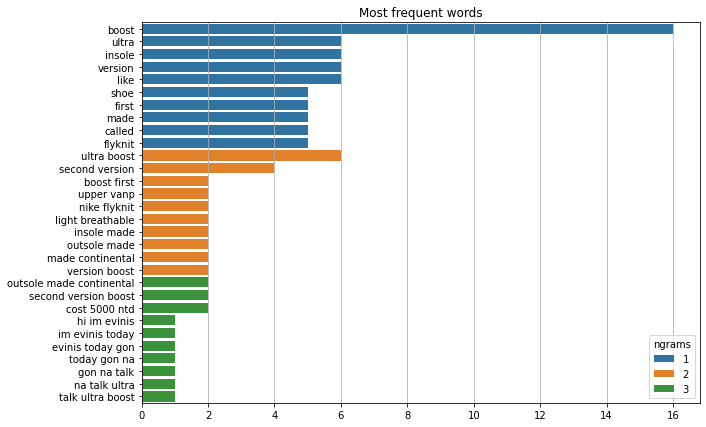

# ABAO3xaiOWQ:


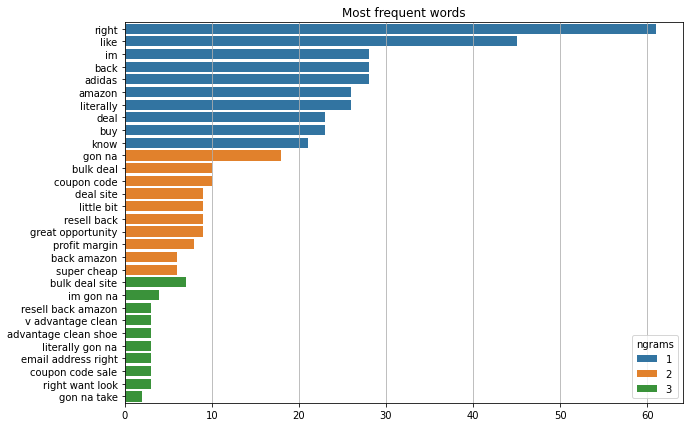

# bgwyK50CmnA:


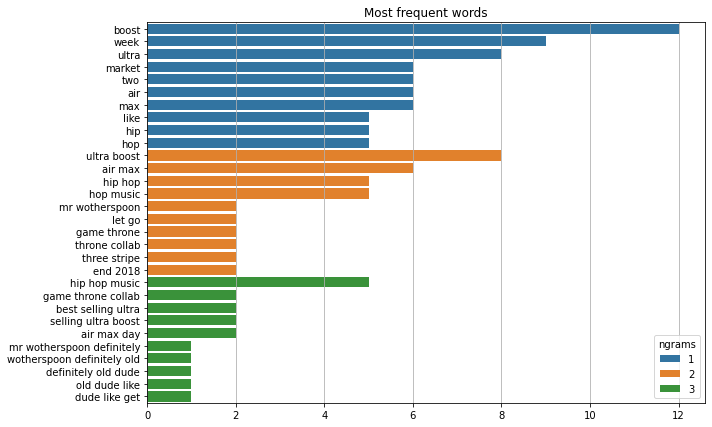

# KXCFkGTBKS0:


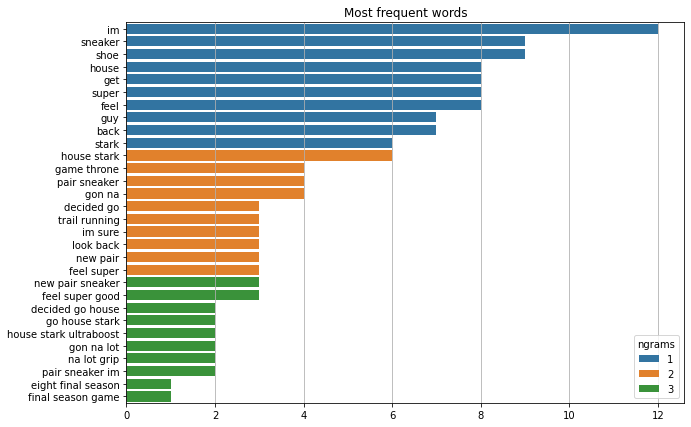

# wXJ6V4XBGTI:


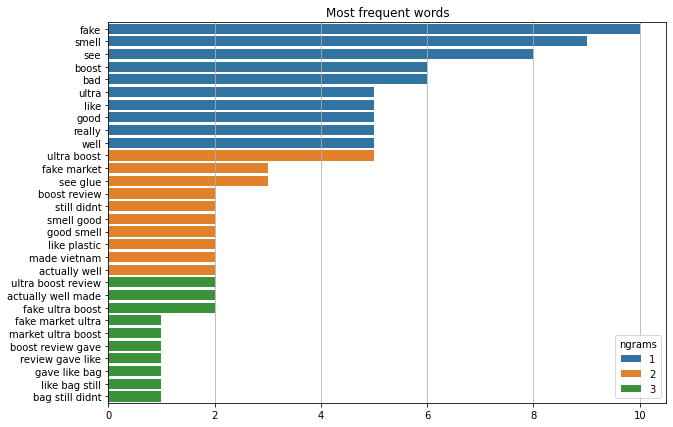

# tSnIj-qhe1M:


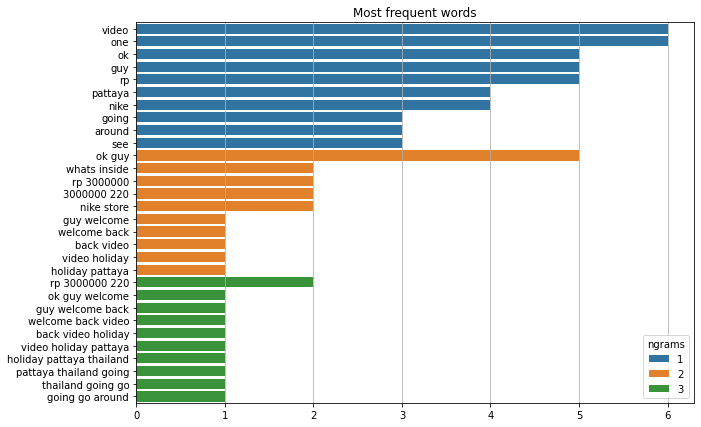

# JIavzgivHyM:


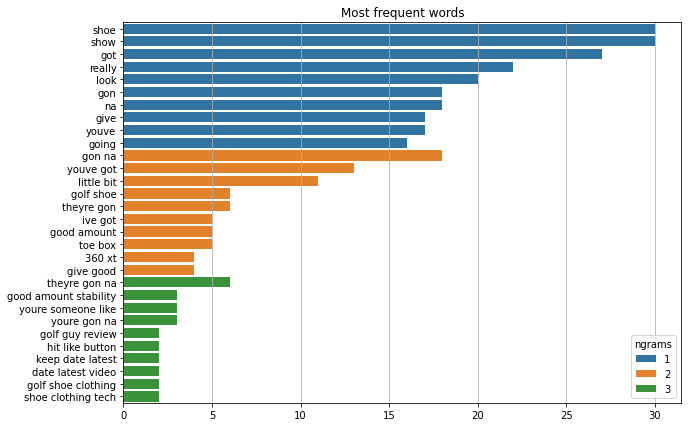

In [123]:
dtf_freq = pd.DataFrame()
for y in dtf["vid_id"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=dtf[dtf["vid_id"]==y]["vid_text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

In [124]:
dtf_freq.sample(5)

word  freq  ngrams            y
1285  need kind anecdotal     1       3  ABAO3xaiOWQ
5                    take     8       1  8XITZ08NqSU
35                   feel     3       1  aNBP-KQKB2o
402            tear point     1       2  QYgs5YBWr14
706     dont want rubbing     1       3  JIavzgivHyM

# pH2_IcMSol0:


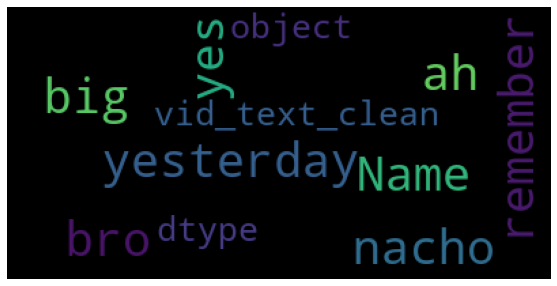

# QYgs5YBWr14:


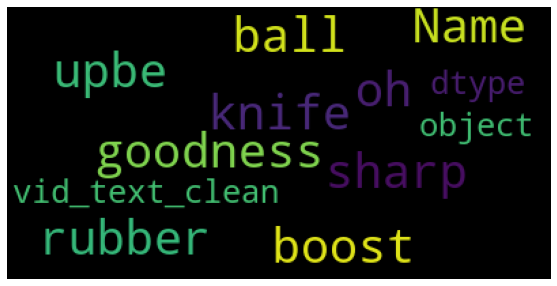

# fVtO4RWRAiw:


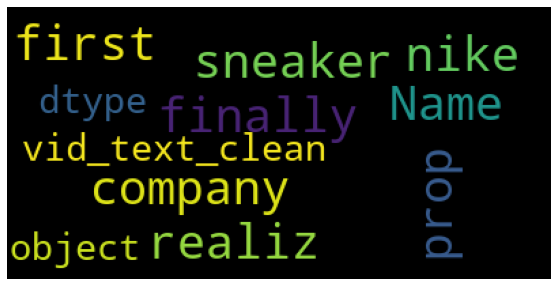

# aNBP-KQKB2o:


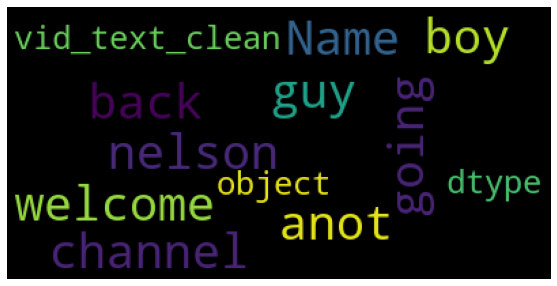

# ZOrufstBacY:


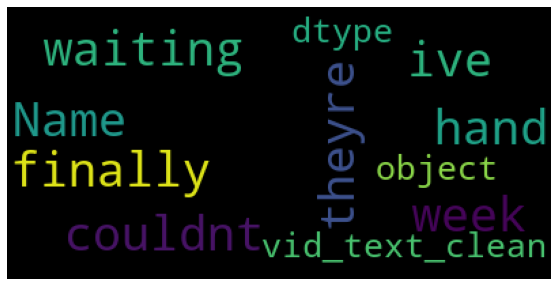

# y_qfu921a1o:


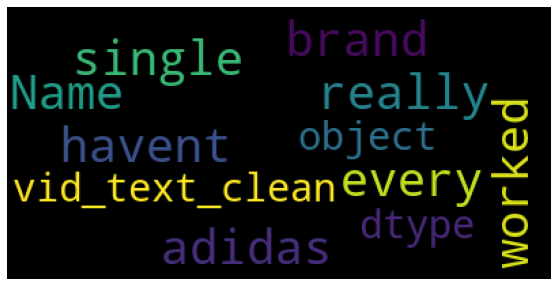

# vAITOCyFzhc:


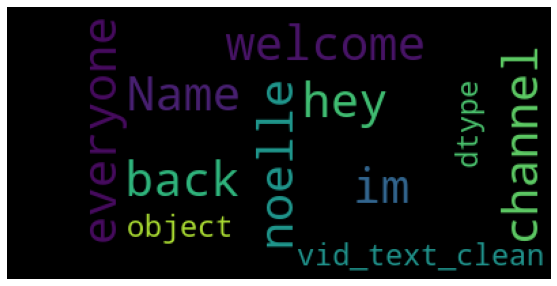

# -xJfo-0wPzE:


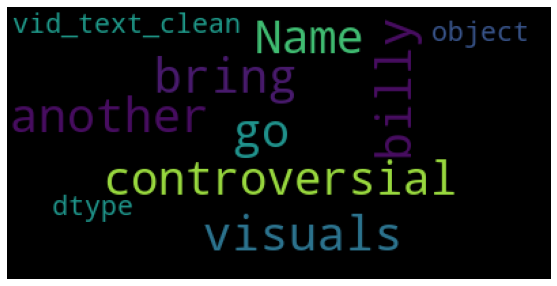

# 5eMEOsEv-VQ:


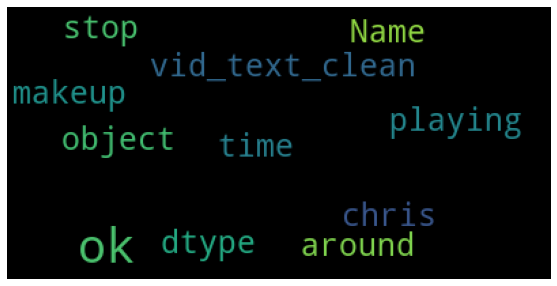

# CsUciHZEM5E:


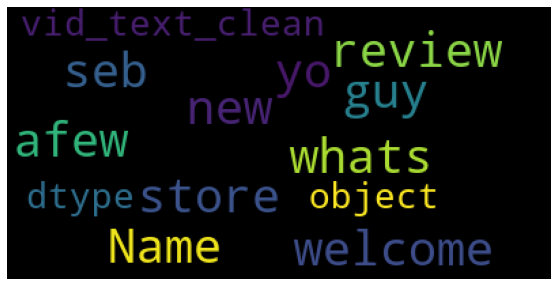

# sMCu6g3MbB4:


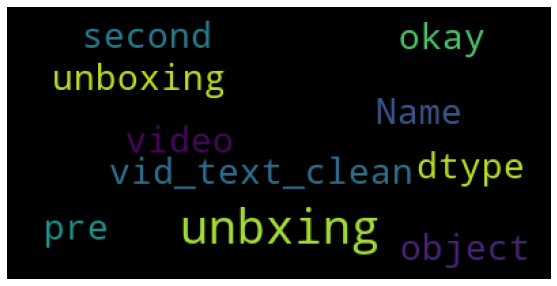

# RUKAjnA11H8:


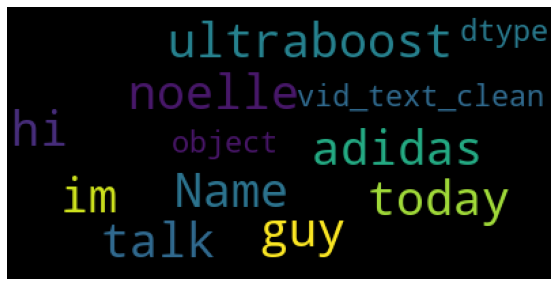

# FuxGiSUzvnc:


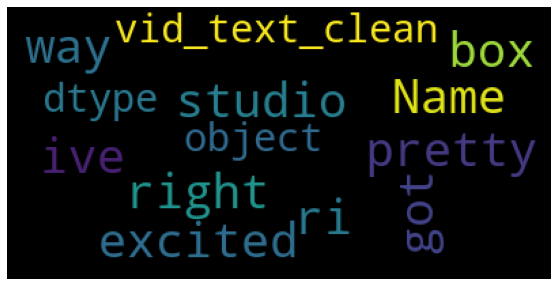

# ErZ3AjBLCfw:


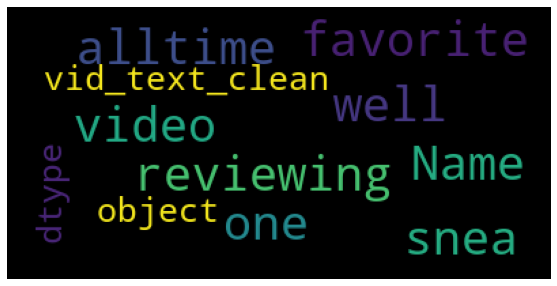

# yoQlNVTTifw:


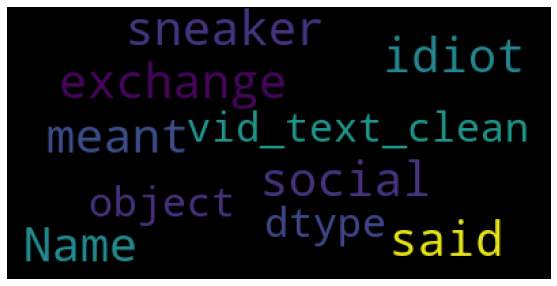

# TihgNApuLgE:


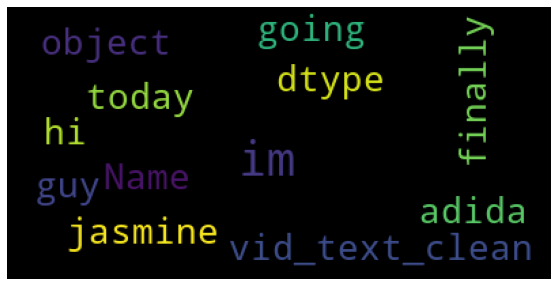

# T26XJdbkyU4:


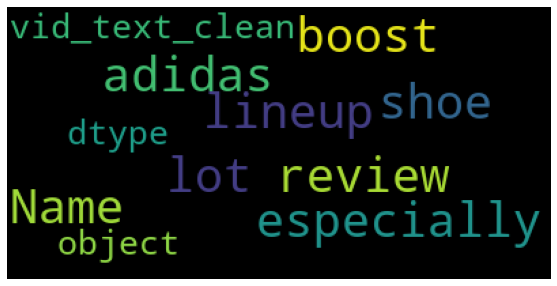

# XOdmzsmRDTE:


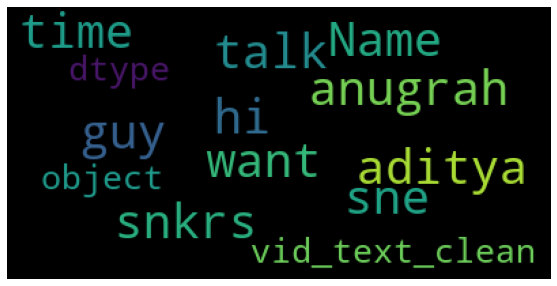

# 7tq482HMX78:


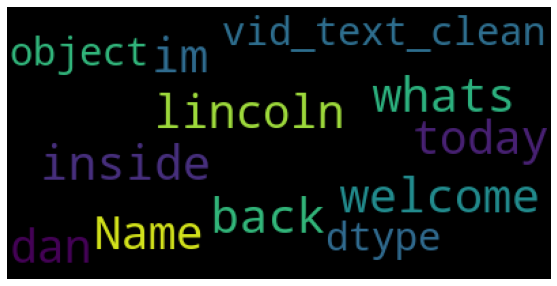

# 8XITZ08NqSU:


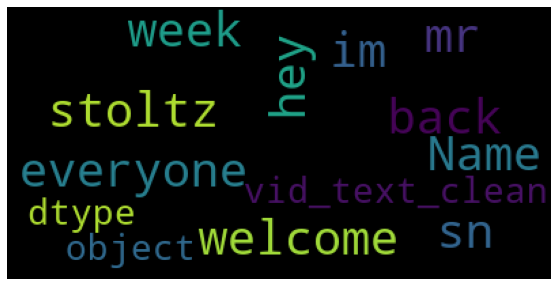

# R61Ahh5lDH8:


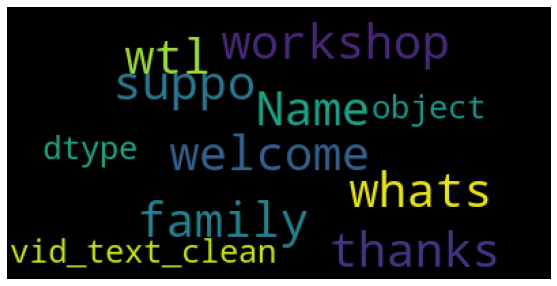

# fLNKYx-A_1Y:


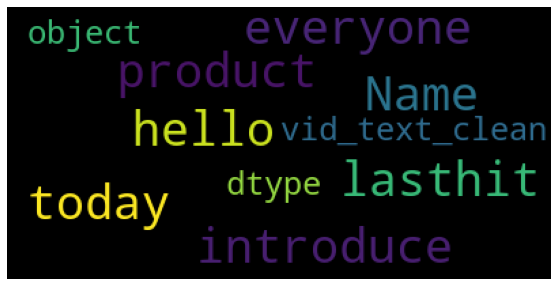

# PcCs6pQ1iFk:


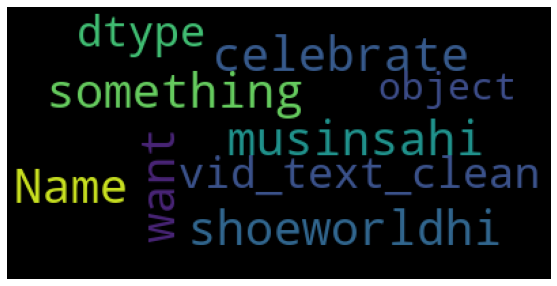

# B8OZxgUHiho:


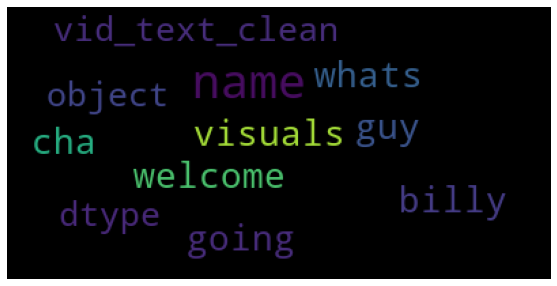

# M46TFlKimYs:


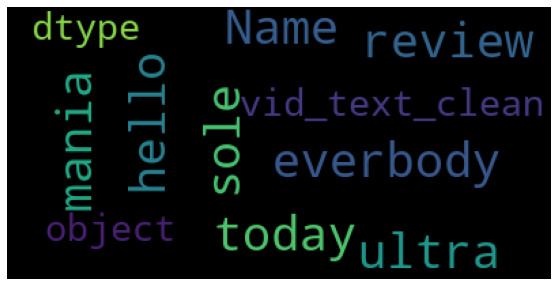

# psRIdqkpAOI:


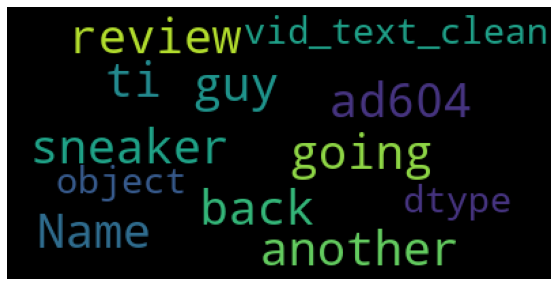

# gvJsNCf5ogo:


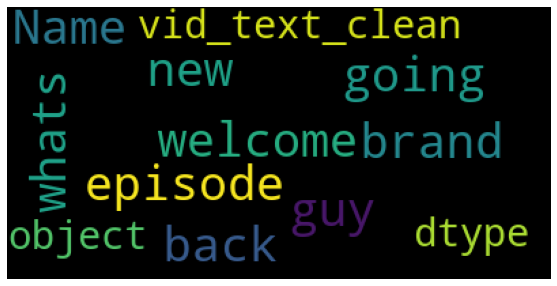

# 32BvpSVvPMw:


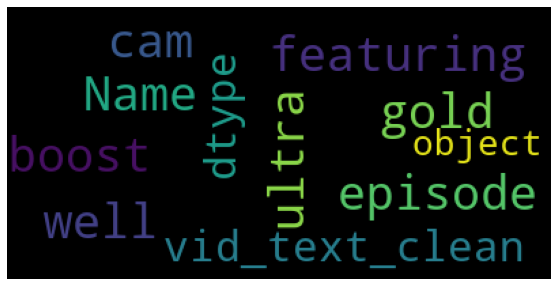

# CPtfs1uZwew:


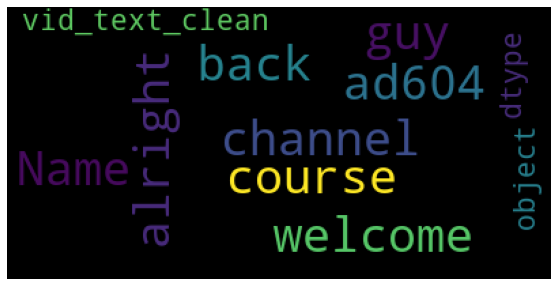

# zYMbCJZljsw:


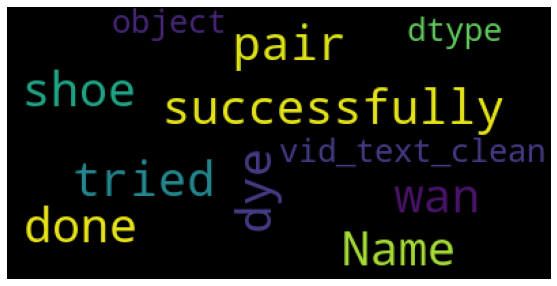

# bStgH_OA0A8:


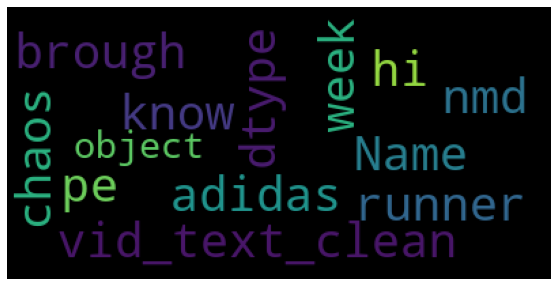

# t0ix1aFp2K4:


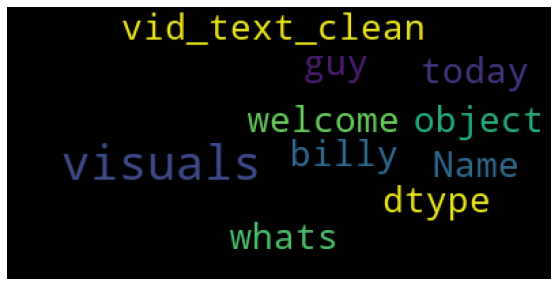

# 3_hHaceDVHA:


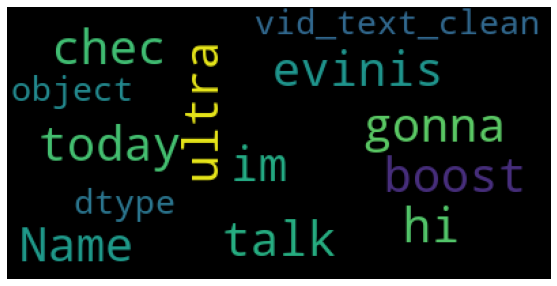

# ABAO3xaiOWQ:


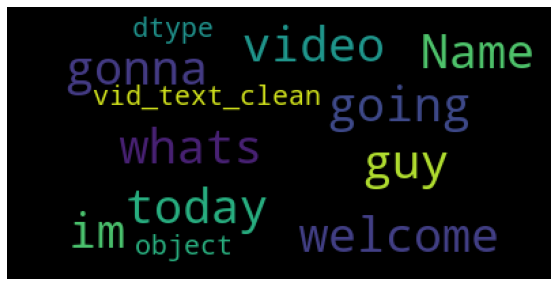

# bgwyK50CmnA:


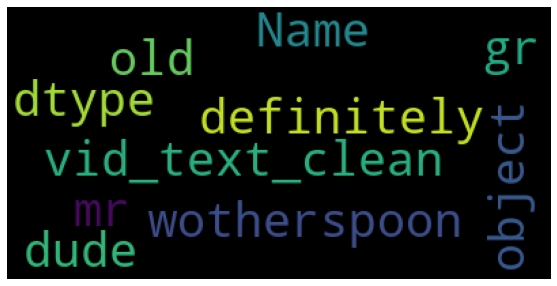

# KXCFkGTBKS0:


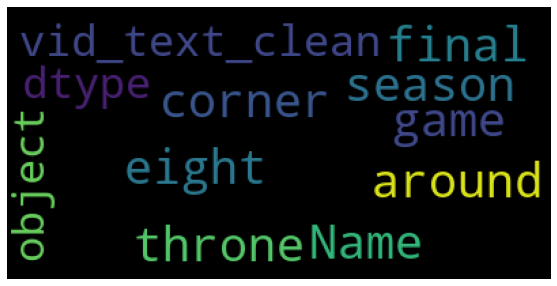

# wXJ6V4XBGTI:


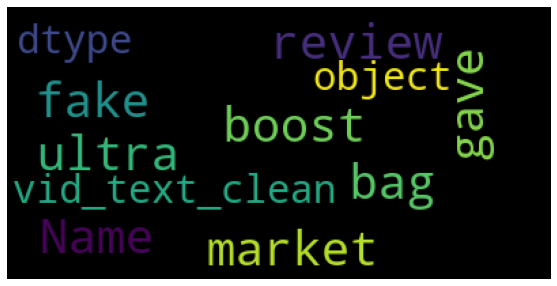

# tSnIj-qhe1M:


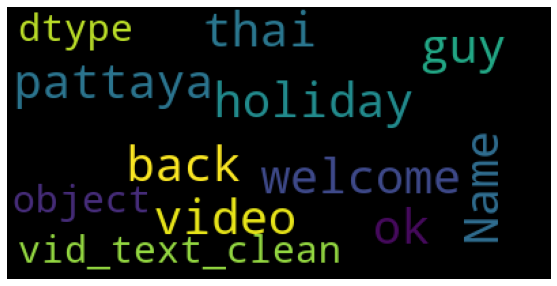

# JIavzgivHyM:


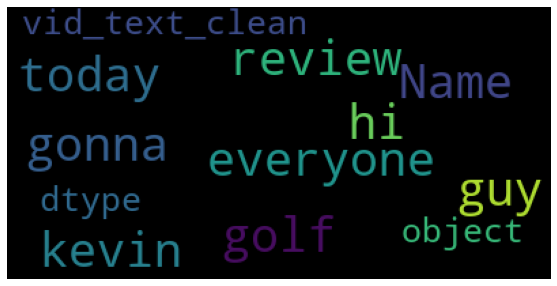

In [125]:
for y in dtf["vid_id"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=dtf[dtf["vid_id"]==y]["vid_text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

In [128]:
dtf = add_word_freq(dtf, "vid_text_clean", lst_words=["Addidas","ultra","boost","ultraboost","addidas ultraboost"], freq="count")
dtf.head()

found records:
['Addidas: 0', 'ultra: 32', 'boost: 35', 'ultraboost: 13', 'addidas ultraboost: 0']


vid_id                                          vid_title  ... ultra boost
0  pH2_IcMSol0  TheRiseandFallofAdidasBoost-WhatHappened-pH2_I...  ...     0    15
1  QYgs5YBWr14     What'sinsideAdidasBoostBall-QYgs5YBWr14.en.csv  ...     2    31
2  fVtO4RWRAiw  NikeEpicReactvsAdidasUltraBoost-TheTruth!-fVtO...  ...     1     4
3  aNBP-KQKB2o  AdidasUltraBoost20(ISS)_Unboxing&OnFootReview-...  ...    12    15
4  ZOrufstBacY  ADIDASULTRABOOSTSUMMER.RDY-UNBOXING-TEST0_16KM...  ...     0     0

[5 rows x 33 columns]

In [129]:
dtf.head()

vid_id                                          vid_title  ... ultra boost
0  pH2_IcMSol0  TheRiseandFallofAdidasBoost-WhatHappened-pH2_I...  ...     0    15
1  QYgs5YBWr14     What'sinsideAdidasBoostBall-QYgs5YBWr14.en.csv  ...     2    31
2  fVtO4RWRAiw  NikeEpicReactvsAdidasUltraBoost-TheTruth!-fVtO...  ...     1     4
3  aNBP-KQKB2o  AdidasUltraBoost20(ISS)_Unboxing&OnFootReview-...  ...    12    15
4  ZOrufstBacY  ADIDASULTRABOOSTSUMMER.RDY-UNBOXING-TEST0_16KM...  ...     0     0

[5 rows x 33 columns]

References:
1. https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/tree/master/natural_language_processing
2.
https://medium.com/@morga046/multi-class-text-classification-with-doc2vec-and-t-sne-a-full-tutorial-55eb24fc40d3
3. https://medium.com/@morga046/creating-an-nlp-data-set-from-youtube-subtitles-fb59c0955c2
4. https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d